In [1]:
import gc
import os
import warnings
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from mpl_toolkits.axisartist.axislines import Axes

warnings.filterwarnings('ignore')

In [73]:
sample_size = 56        # 24, 56
plots_dir = os.path.join('out', 'plots', f'n{sample_size}')
calculations_dir = os.path.join('out', 'calculations', f'n{sample_size}')

os.makedirs(plots_dir, exist_ok=True)
os.makedirs(calculations_dir, exist_ok=True)

metrics = {
    # 'sb.bin': 'Stereotypical bias',     # TODO add to shared calculations
    'acc_equality_diff.bin': 'Accuracy equality difference',
    # 'acc_equality_ratio.bin': 'Accuracy equality ratio',
    # 'disp_impact.bin': 'Disparate impact',
    'equal_opp_diff.bin': 'Equal opportunity difference',
    # 'equal_opp_ratio.bin': 'Equal opportunity ratio',
    'pred_equality_diff.bin': 'Predictive equality difference',
    # 'pred_equality_ratio.bin': 'Predictive equality ratio',
    'stat_parity.bin': 'Statistical parity',
    'neg_pred_parity_diff.bin': 'Negative predictive parity difference',
    # 'neg_pred_parity_ratio.bin': 'Negative predictive parity ratio',
    'pos_pred_parity_diff.bin': 'Positive predictive parity difference',
    # 'pos_pred_parity_ratio.bin': 'Positive predictive parity ratio',
}

plt.style.use('default')

In [74]:
with open(path.join(calculations_dir, 'gr.bin'), 'rb') as f:
    gr = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=['gr'])

with open(path.join(calculations_dir, 'ir.bin'), 'rb') as f:
    ir = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=['ir'])

In [4]:
# # old code - plotnine
#
# def get_plot(df, metric):
#     fig = plotnine.ggplot(df, plotnine.aes(x=metric, fill='typeVal'))
#     fig += plotnine.geom_histogram(plotnine.aes(y=plotnine.after_stat('count / np.sum(count)')), bins=50)
#     fig += plotnine.scale_fill_manual(values={'NaN': '#ca0020', 'not NaN': '#404040'}, guide=False)
#     fig += plotnine.facet_grid('ir~gr', labeller='label_both')
#     fig += plotnine.scale_x_continuous(labels=lambda lst: [x if x != -1.5 else 'NaN' for x in lst])
#     fig += plotnine.theme_minimal()
#     fig += plotnine.theme(figure_size=(16, 8))
#     fig += plotnine.ggtitle(f'{metric} for selected IR & GR')
#     fig += plotnine.ylab('Probability')
#     return fig
#
#
# for metric_file, metric_name in metrics.items():
#     with open(path.join(calculations_dir, metric_file), 'rb') as f:
#         metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[metric_name])
#     df = pd.concat([gr, ir], axis=1)
#     df = pd.concat([df, metric], axis=1)
#     df = df.loc[df.ir.isin(ir_selected) & df.gr.isin(gr_selected)]
#     df.replace(np.nan, -1.5, inplace=True)
#     df['typeVal'] = np.where(df[metric_name] == -1.5, 'NaN', 'not NaN')
#
#     fig = get_plot(df, metric_name)
#     print(fig)
#     fig.save(path.join(plots_dir, f'p9_{metric_name}_hist.png'), width=16, height=8, dpi=300)
#
#     del metric
#     del df
#     gc.collect()

## matplotlib
### v1 - ignoring NaNs

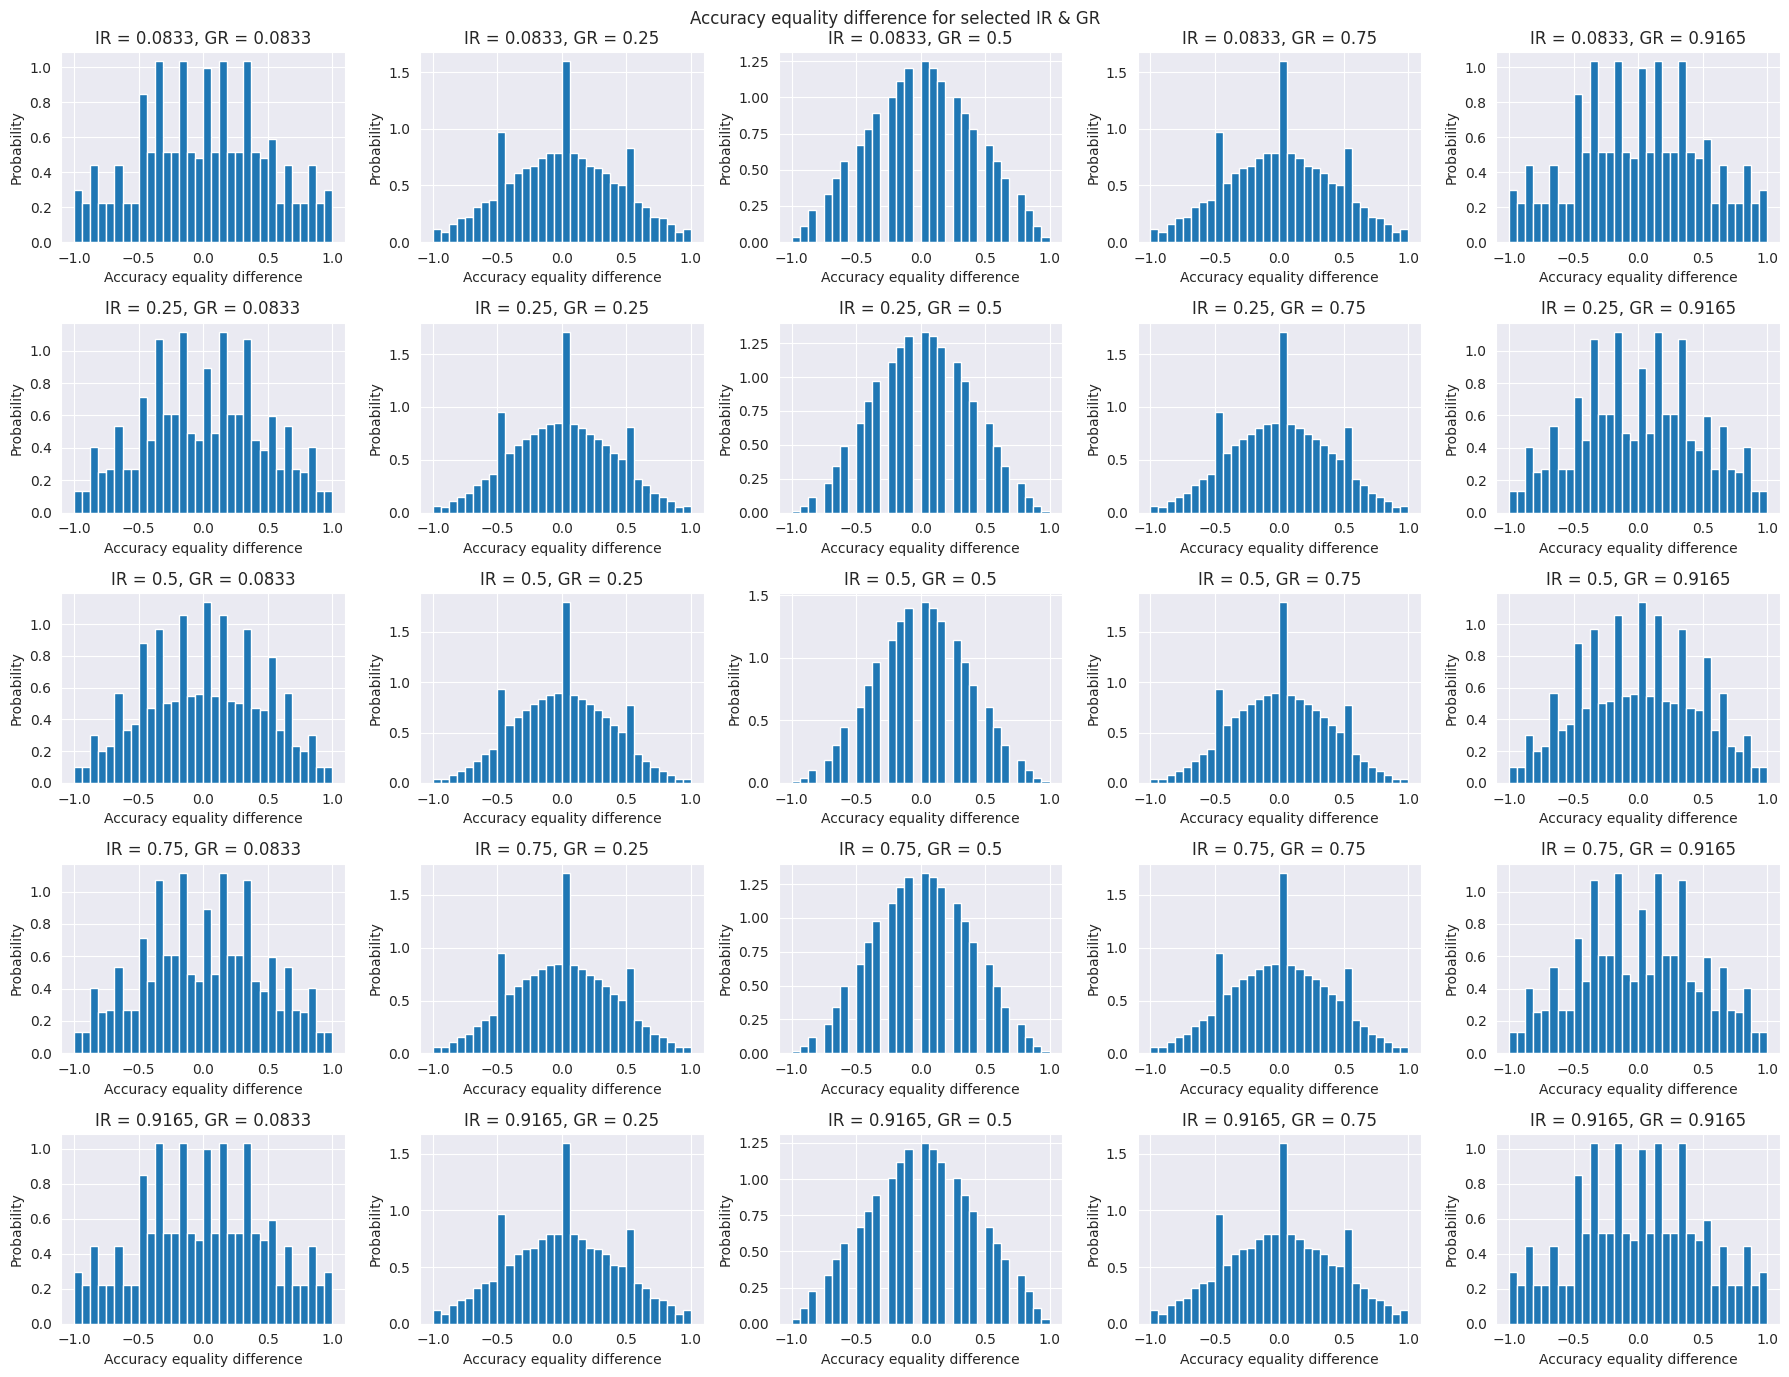

In [5]:
# same in matplotlib
BINS = 32

ratios = [1./12, 1./4, 1./2, 3./4, 11./12]
ir_selected = np.float16(ratios)
gr_selected = np.float16(ratios)

for metric_file, metric_name in metrics.items():
    with open(path.join(calculations_dir, metric_file), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[metric_name])
    # print(np.unique(gr), np.unique(ir))
    # merge info about metric values and balance ratios
    df = pd.concat([gr, ir, metric], axis=1)
    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(ir_selected) & df.gr.isin(gr_selected)]
    df.replace(np.inf, np.nan, inplace=True)
    df.replace(np.nan, -1.5, inplace=True)
    df['typeVal'] = np.where(df[metric_name] == -1.5, 'NaN', 'not NaN')

    fig, ax = plt.subplots(len(ir_selected), len(gr_selected),
                           figsize=(18, 14))

    for i, ir_val in enumerate(ir_selected):
        for g, gr_val in enumerate(gr_selected):
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
            ax[i, g].hist(df_tmp[metric_name], bins=BINS, density=True)       # err: acc_equality_ratio
            ax[i, g].set_title(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')
            ax[i, g].set_xlabel(metric_name)
            ax[i, g].set_ylabel('Probability')                    # TODO probability normalisation
            # ax[i, g].legend()

    # ax.set_title(f'{metric_name} for selected IR & GR')
    # ax.set_xlabel(metric_name)
    # ax.set_ylabel('Probability')
    # ax.legend()

    fig.suptitle(f'{metric_name} for selected IR & GR')
    fig.tight_layout()

    fig.savefig(path.join(plots_dir, f'MPL_{metric_name}.png'), dpi=300)

    del metric
    del df
    gc.collect()

    break

In [6]:
def plot_histograms_01(metric_info, gr_selected, ir_selected, bins):
    metric_file, metric_name = metric_info

    with open(path.join(calculations_dir, metric_file), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[metric_name])
    # merge info about metric values and balance ratios
    df = pd.concat([gr, ir, metric], axis=1)
    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(ir_selected) & df.gr.isin(gr_selected)]
    df = df.replace(np.inf, np.nan).replace(np.nan, -1.5)
    df['typeVal'] = np.where(df[metric_name] == -1.5, 'NaN', 'not NaN')

    fig, ax = plt.subplots(len(ir_selected), len(gr_selected), figsize=(18, 14))

    for i, ir_val in enumerate(ir_selected):
        for g, gr_val in enumerate(gr_selected):
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]

            # ax[i, g].hist(df_tmp[metric_name], bins=bins, density=True)       # err: acc_equality_ratio
            binned, edges = np.histogram(df_tmp[metric_name], bins=bins)
            binned = binned / df_tmp.shape[0]

            ax[i, g].hist(edges[:-1], edges, weights=binned)

            ax[i, g].set_title(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')
            ax[i, g].set_xlabel(metric_name)
            ax[i, g].set_ylabel('Probability')

    fig.suptitle(f'{metric_name} for selected IR & GR')
    fig.tight_layout()
    # fig.savefig(path.join(plots_dir, f'MPL_{metric_name}.png'), dpi=300)

    del metric
    del df
    gc.collect()
    return fig

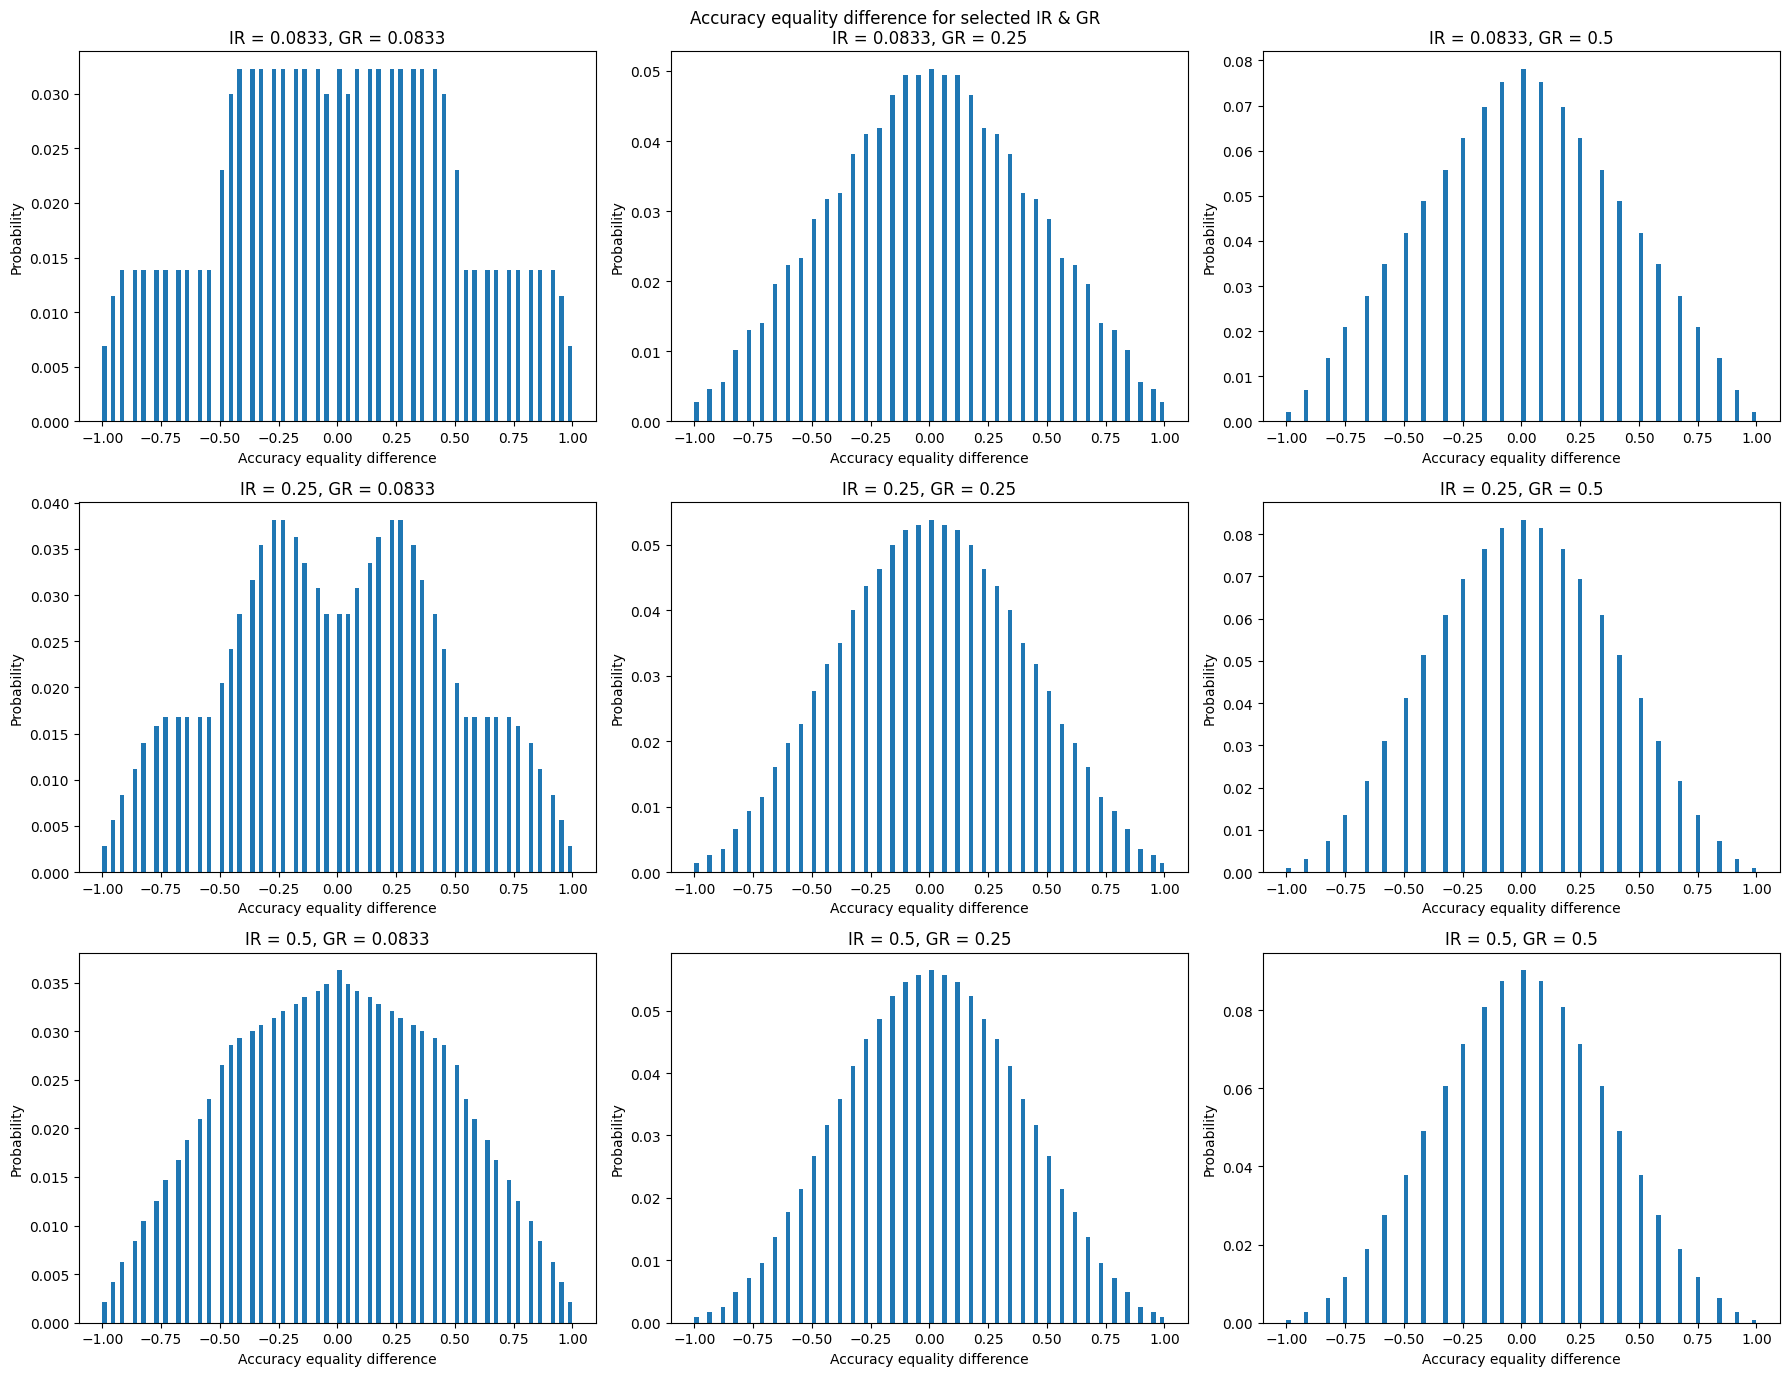

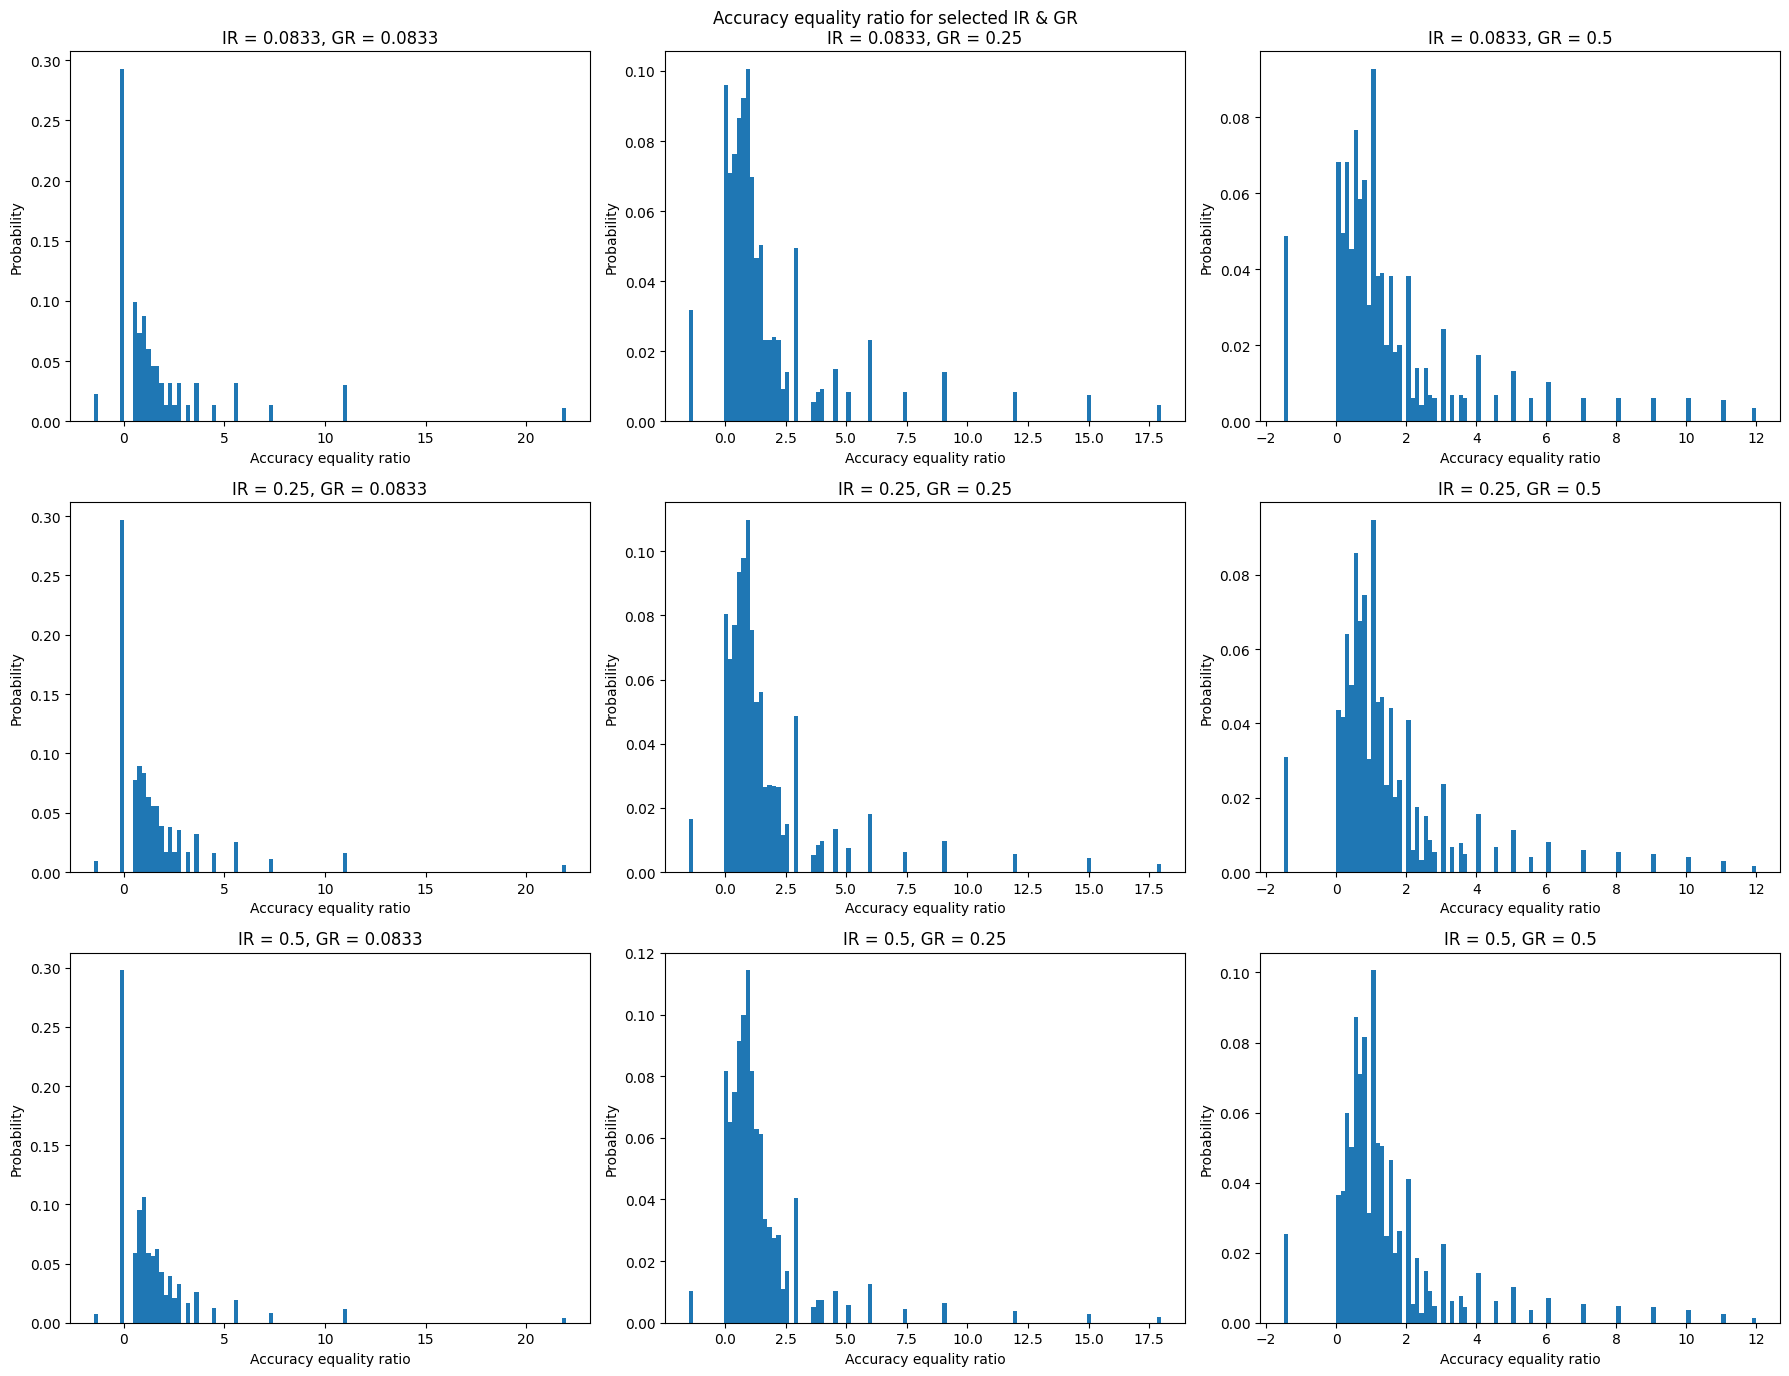

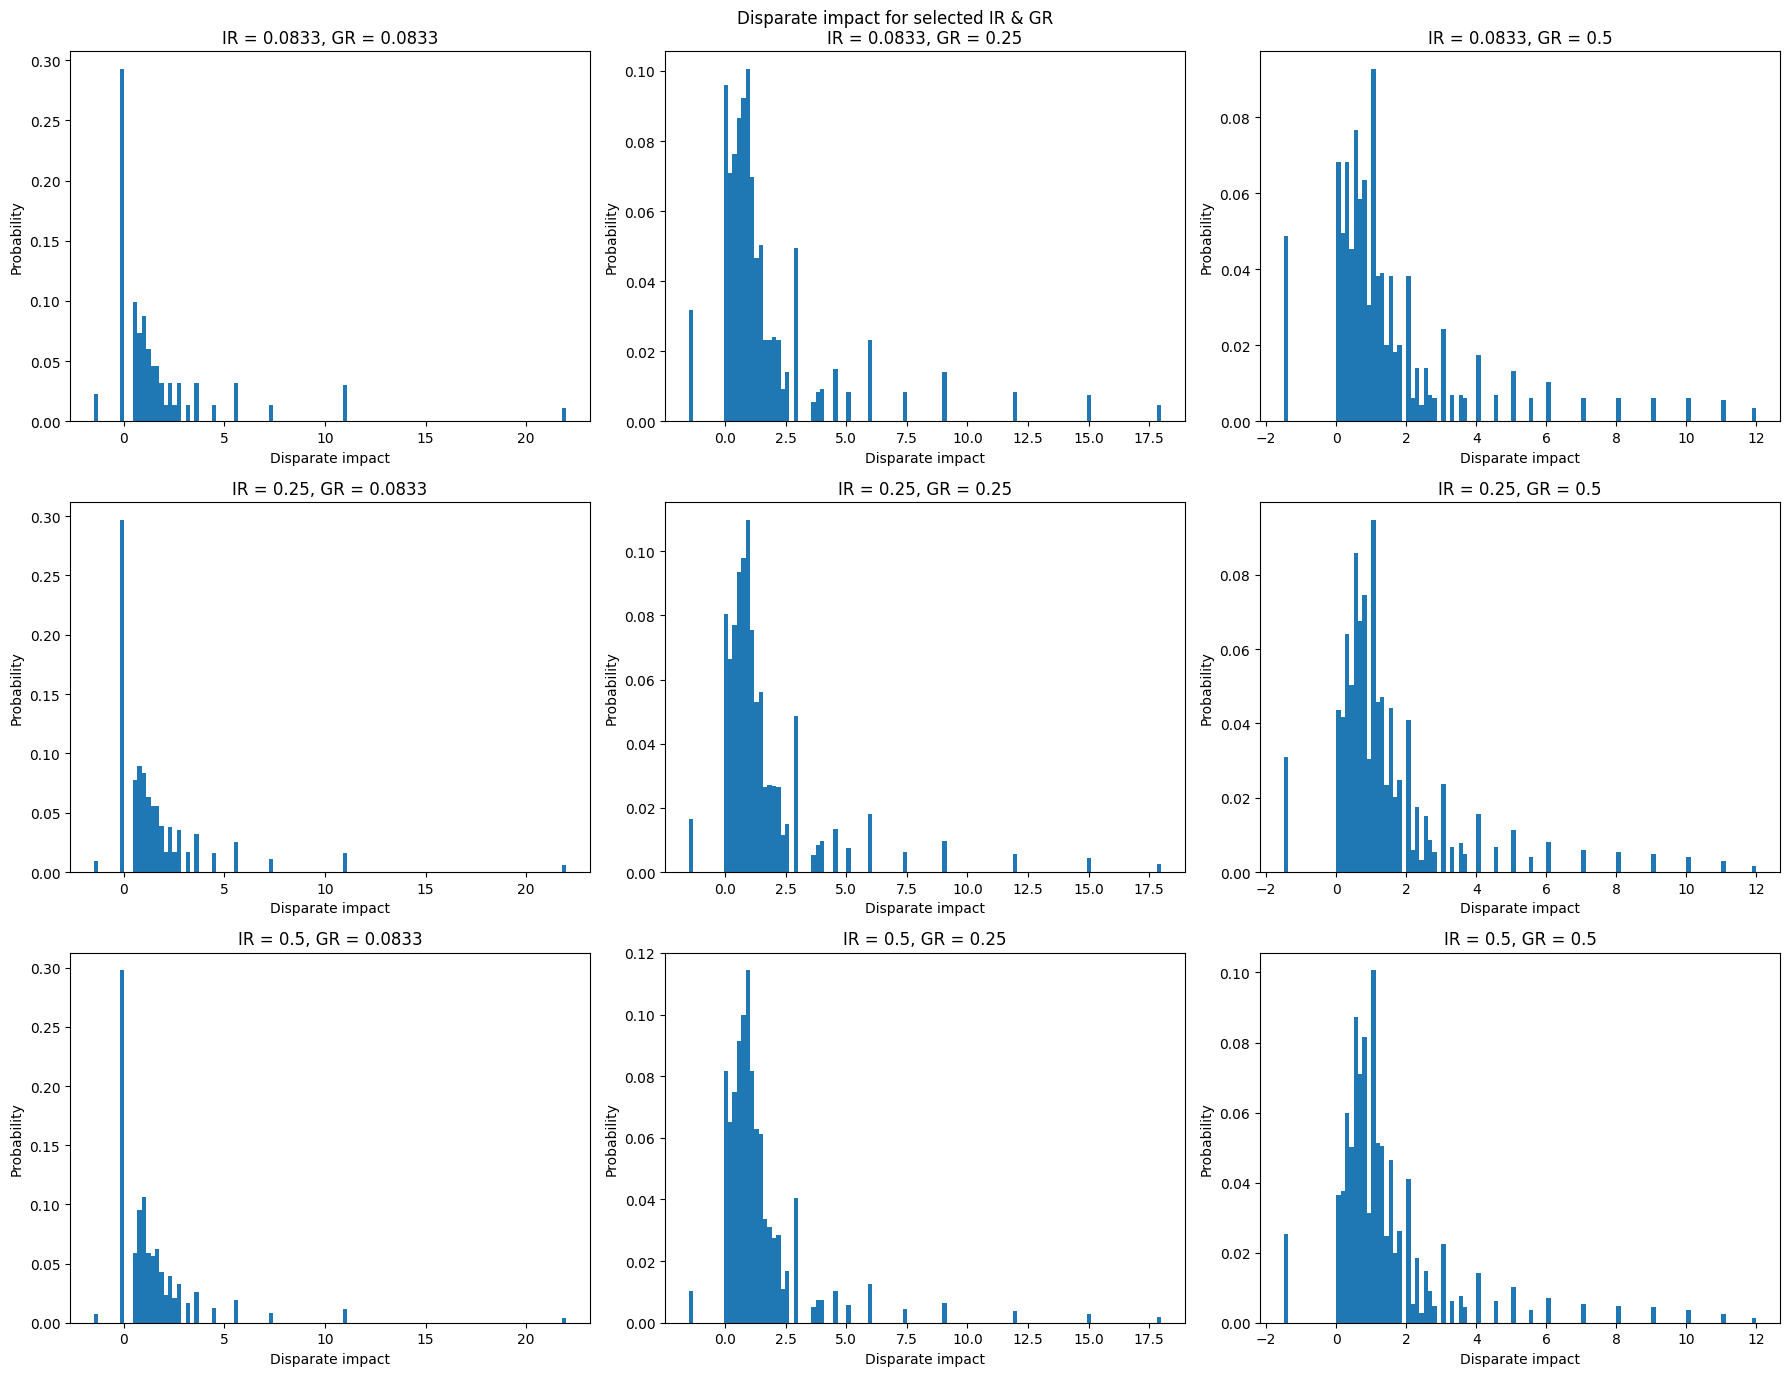

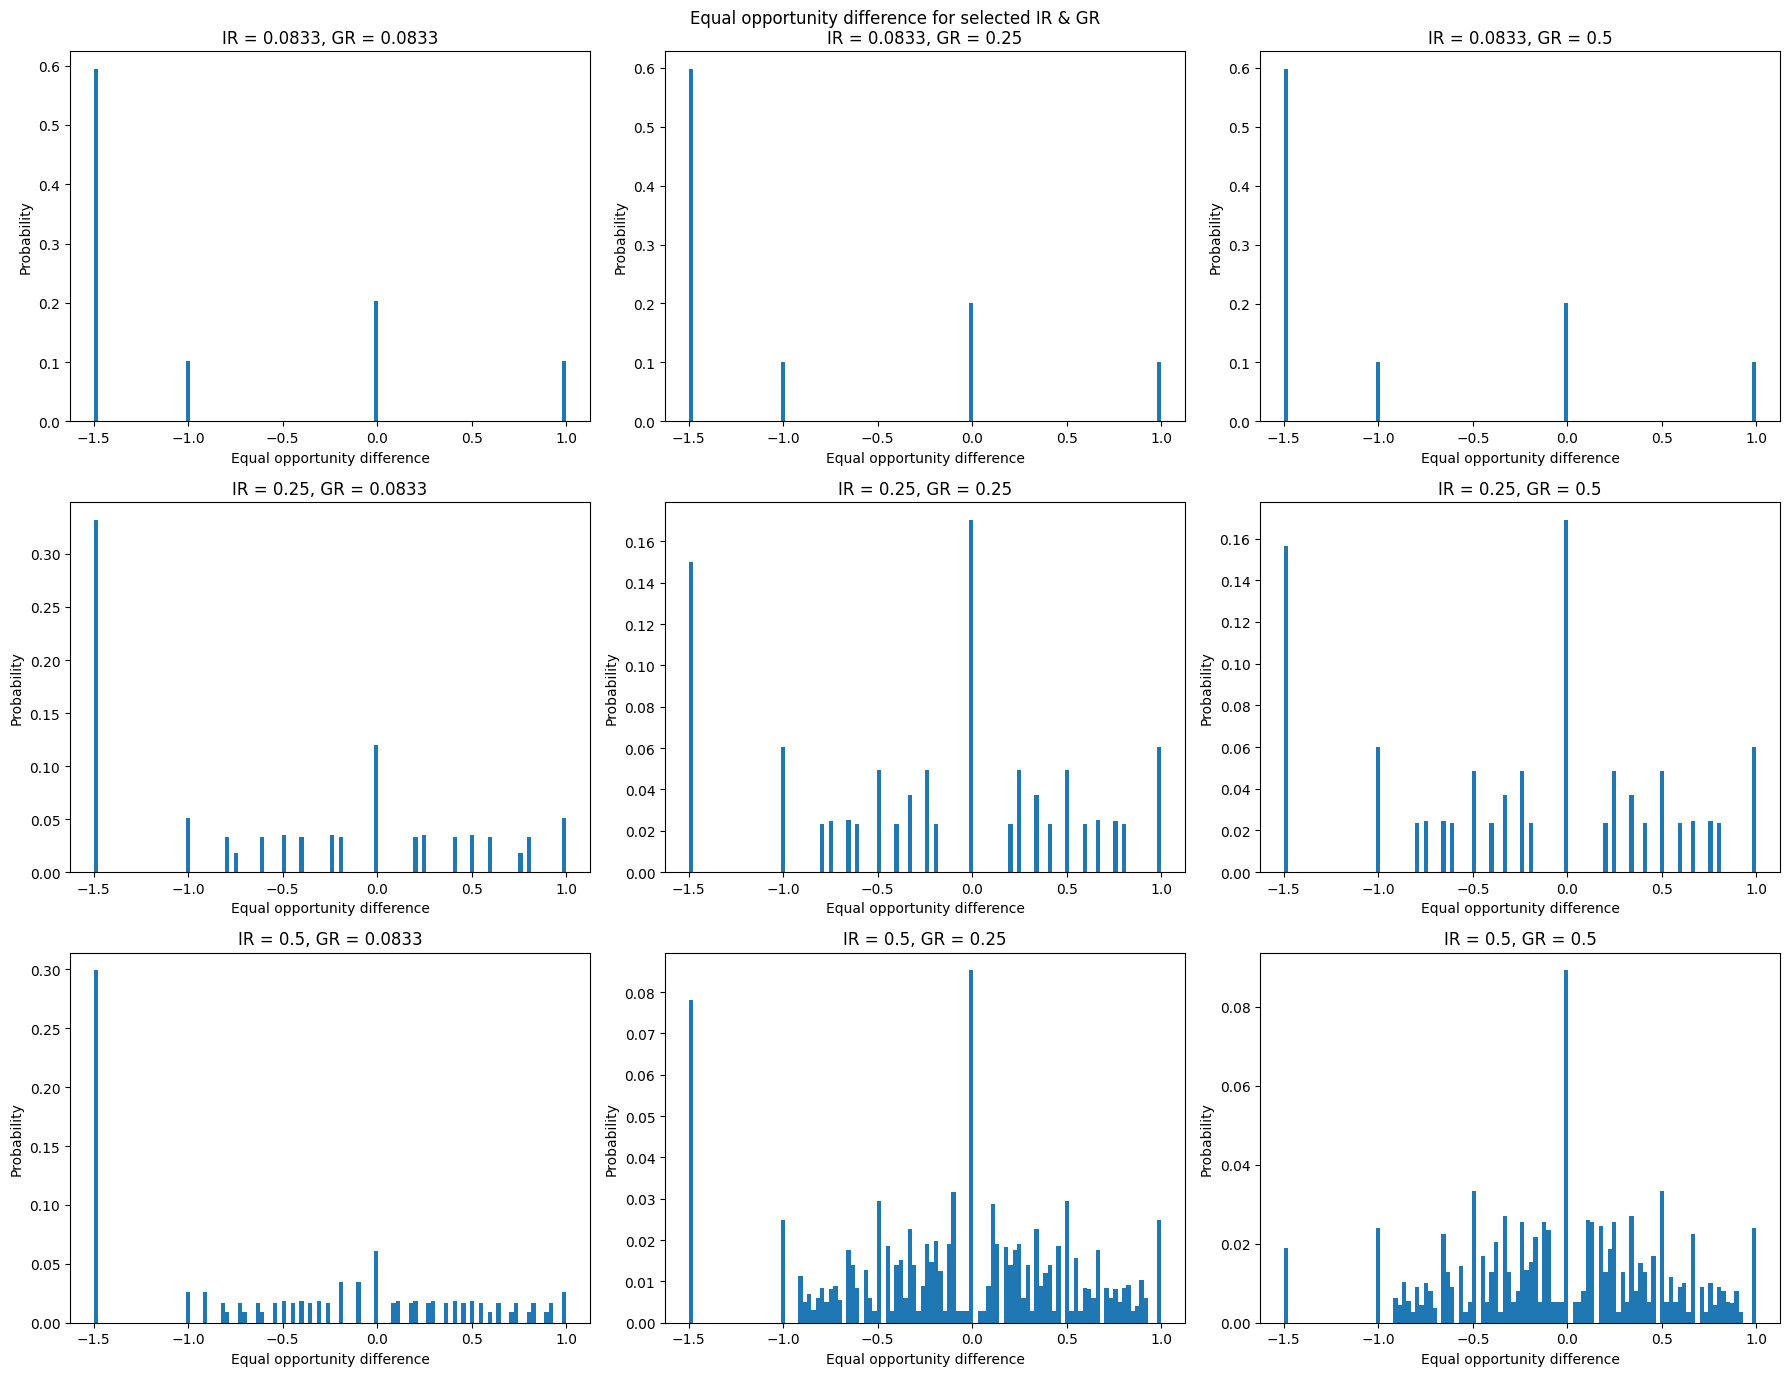

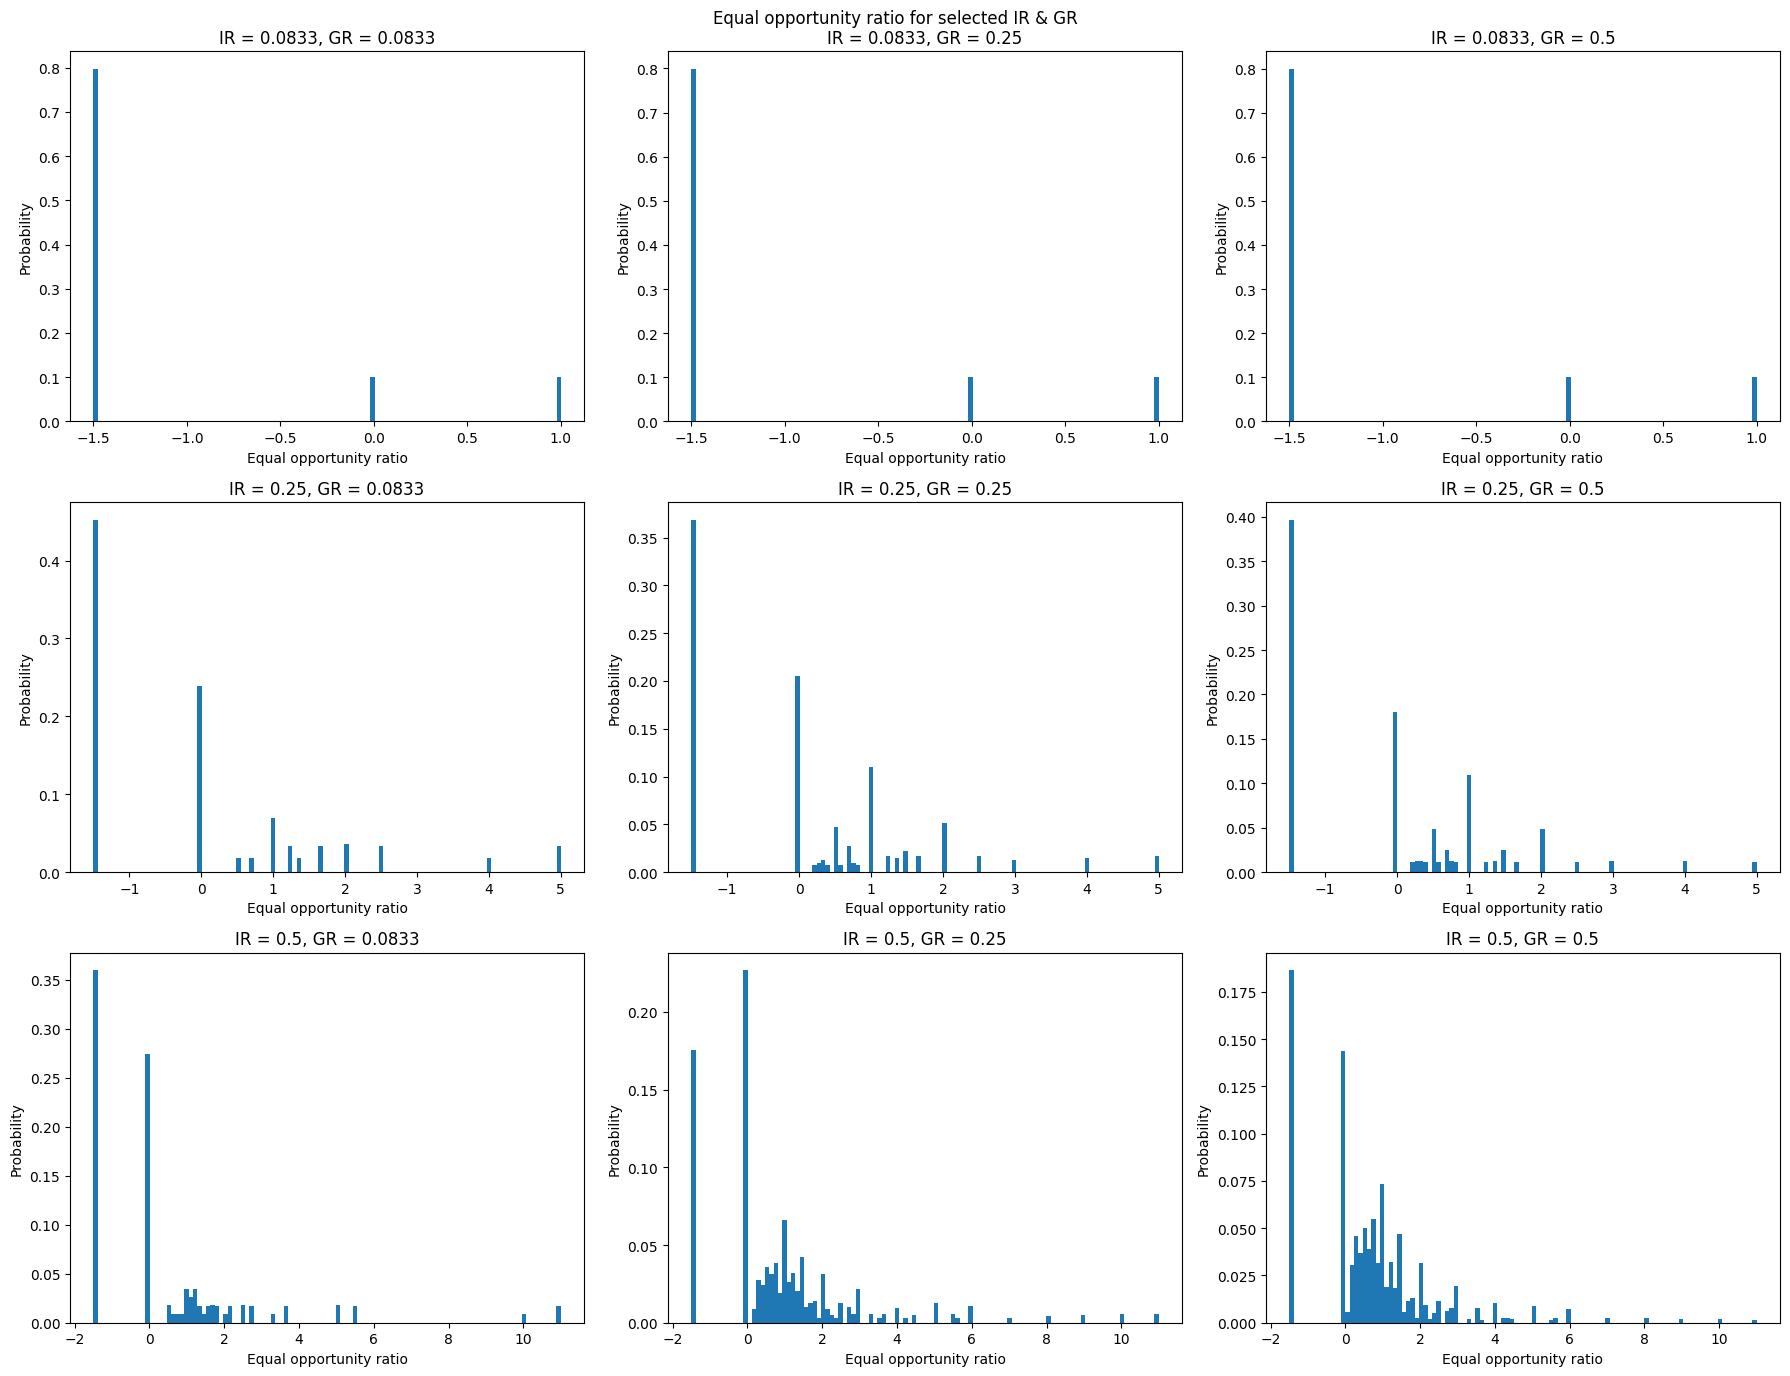

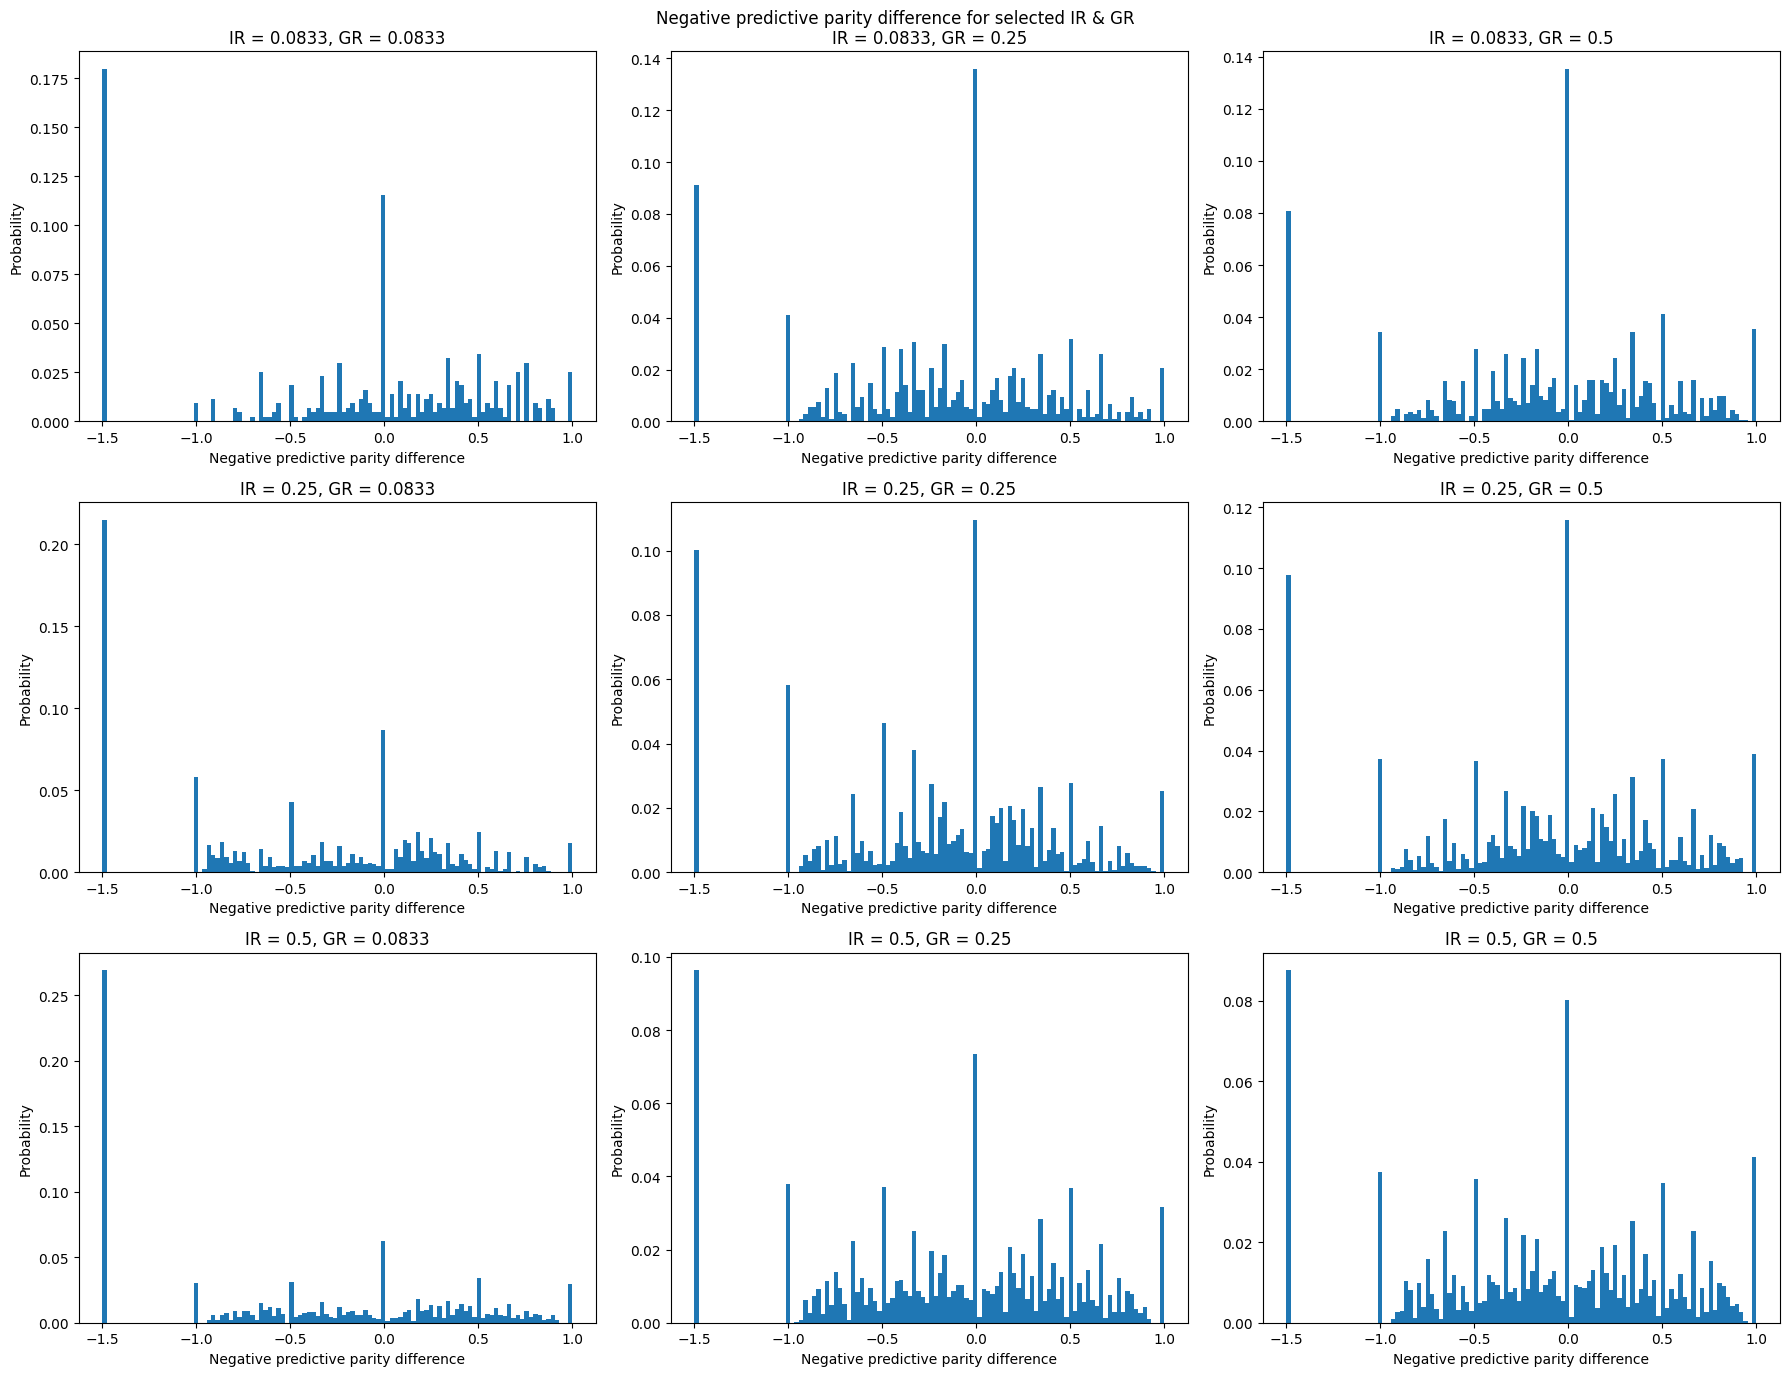

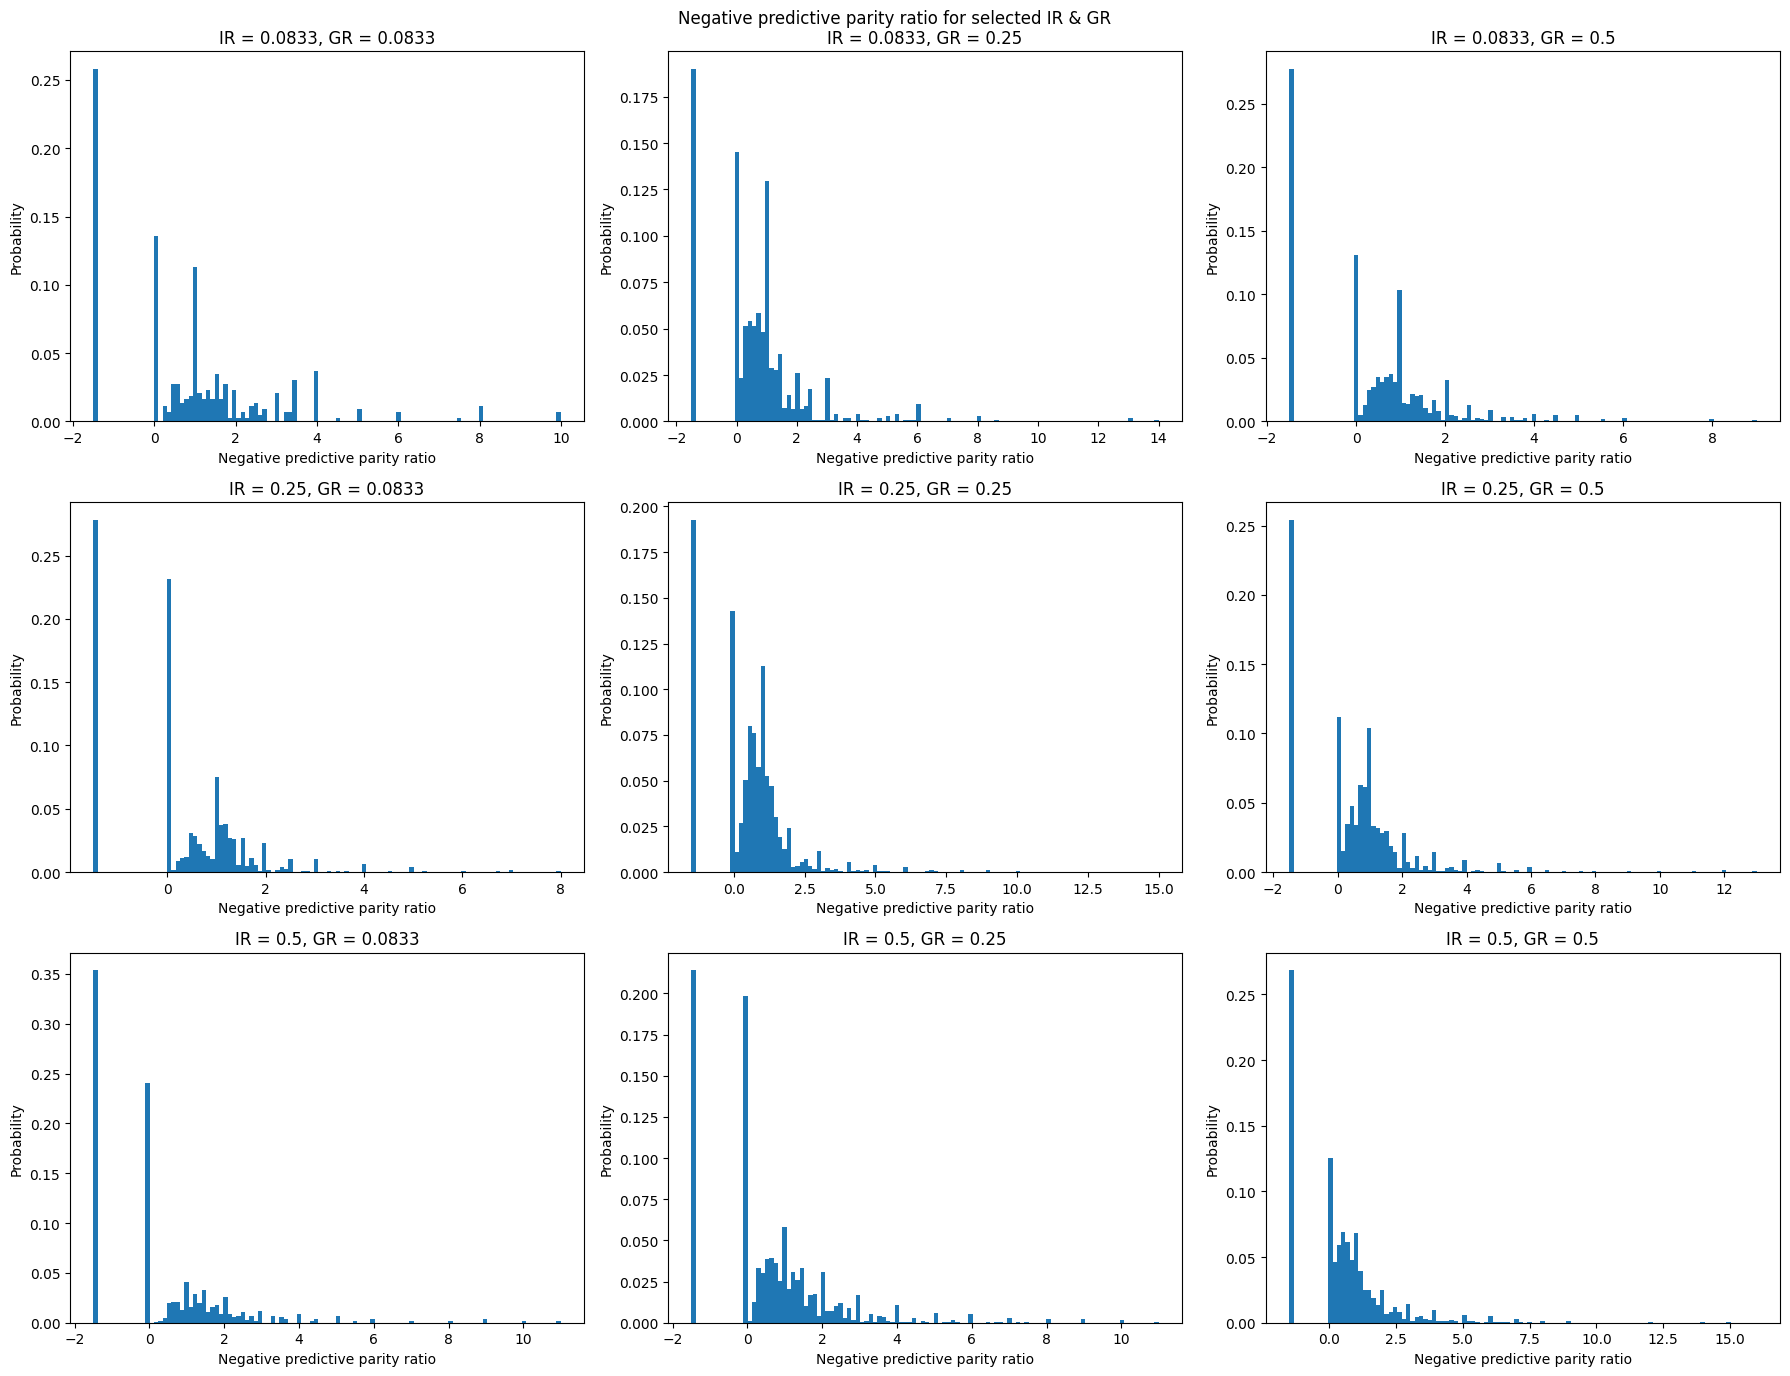

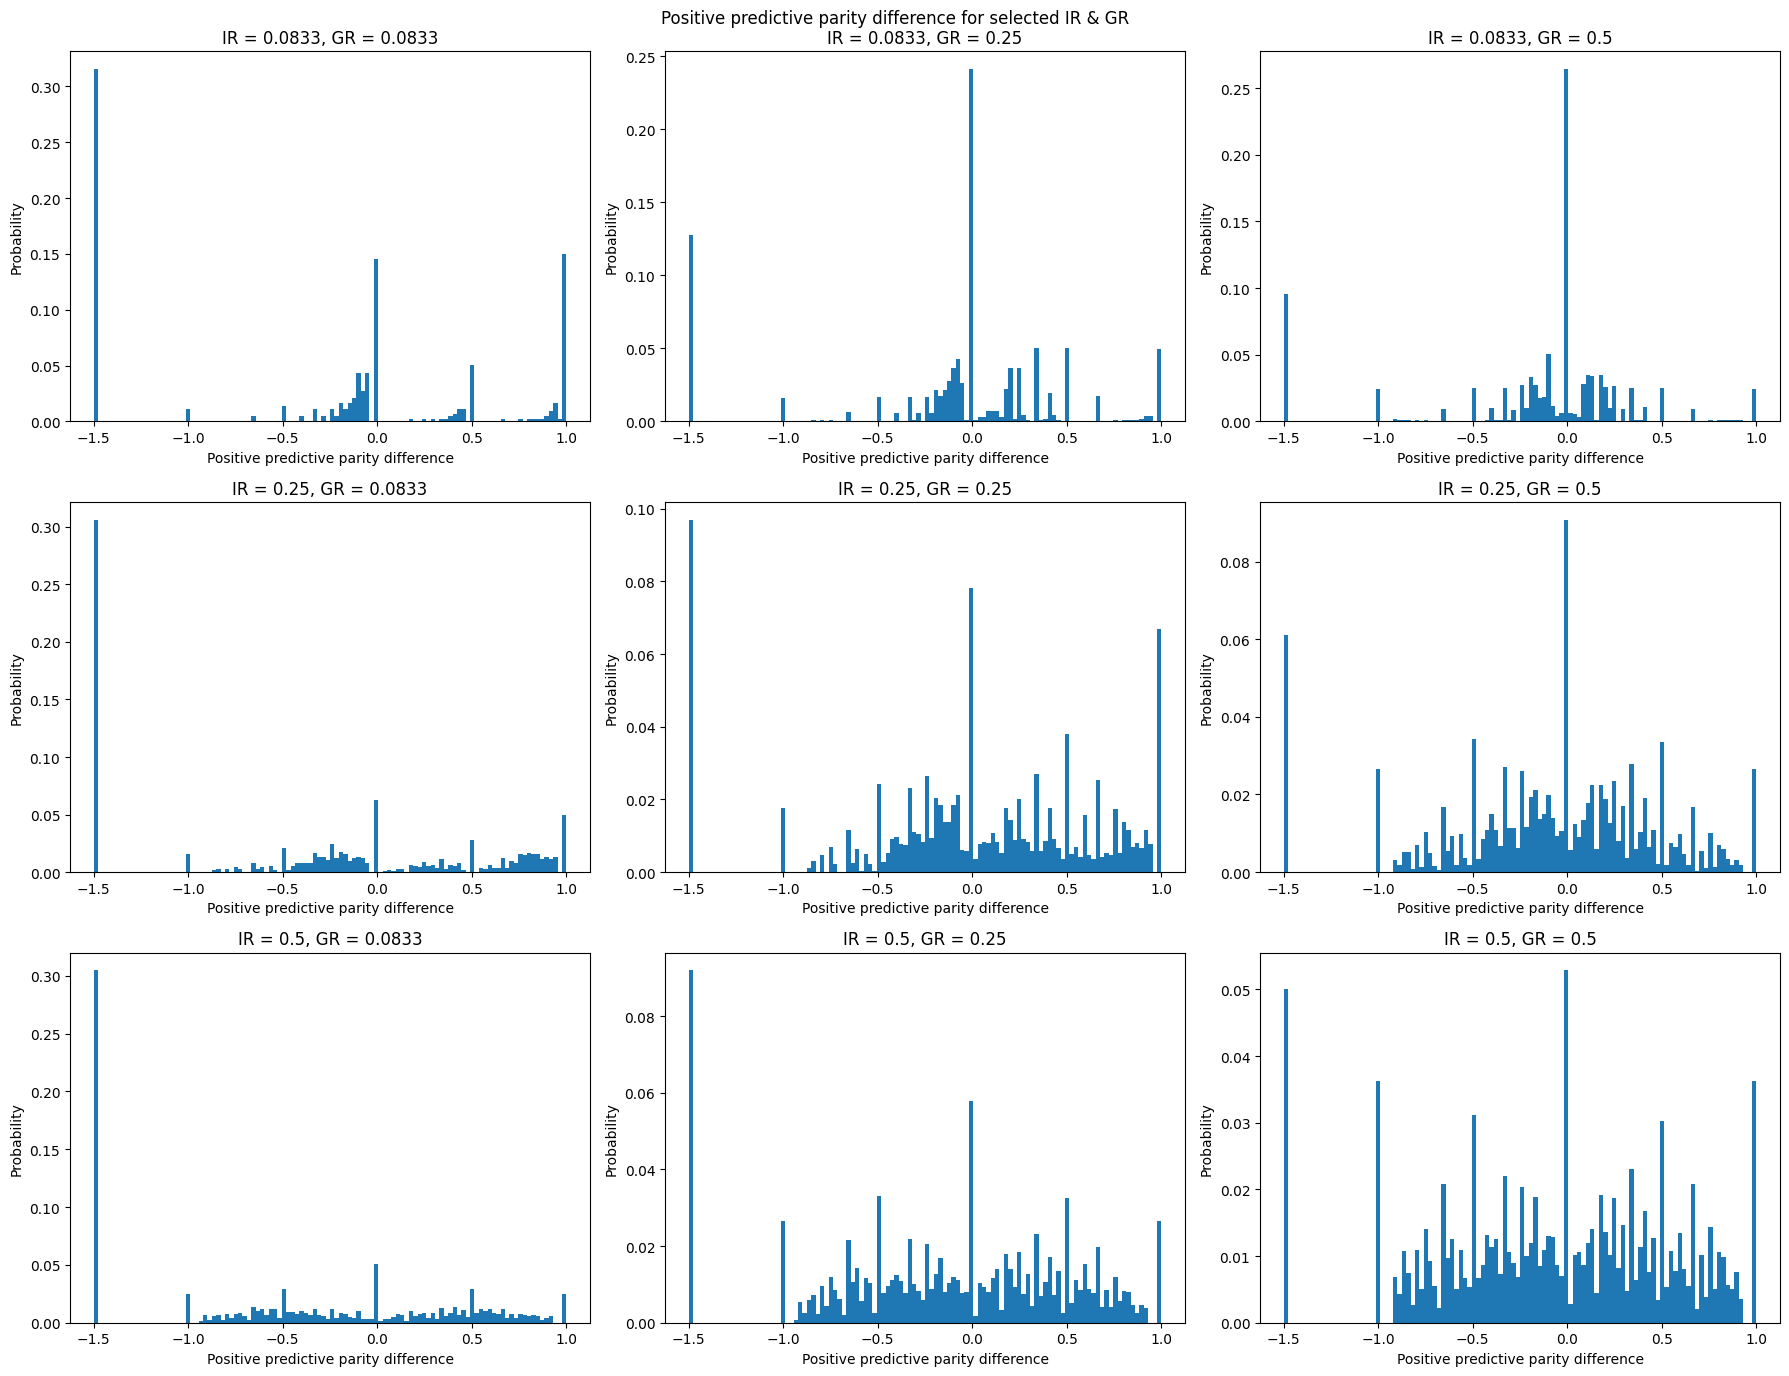

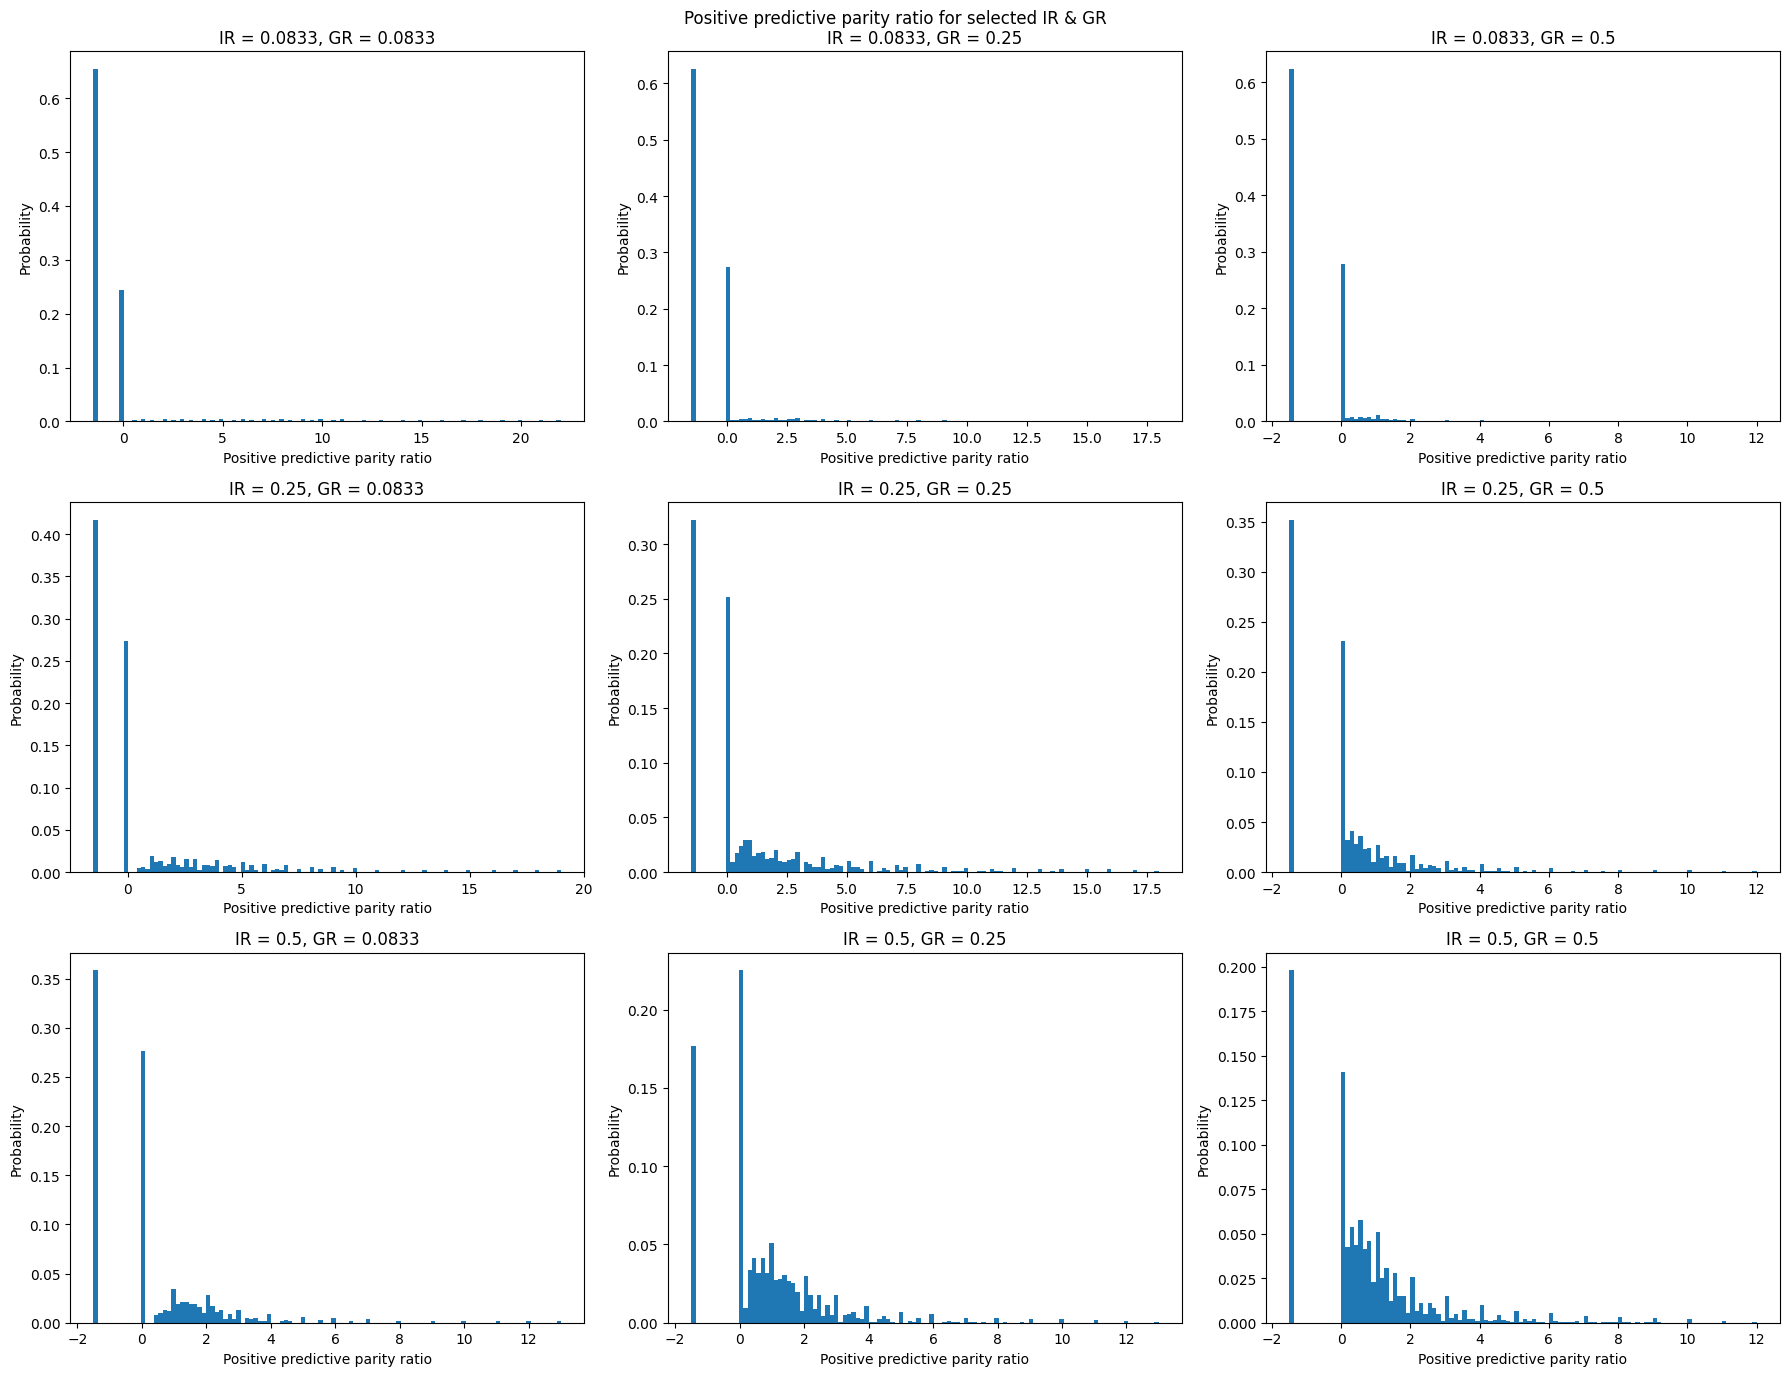

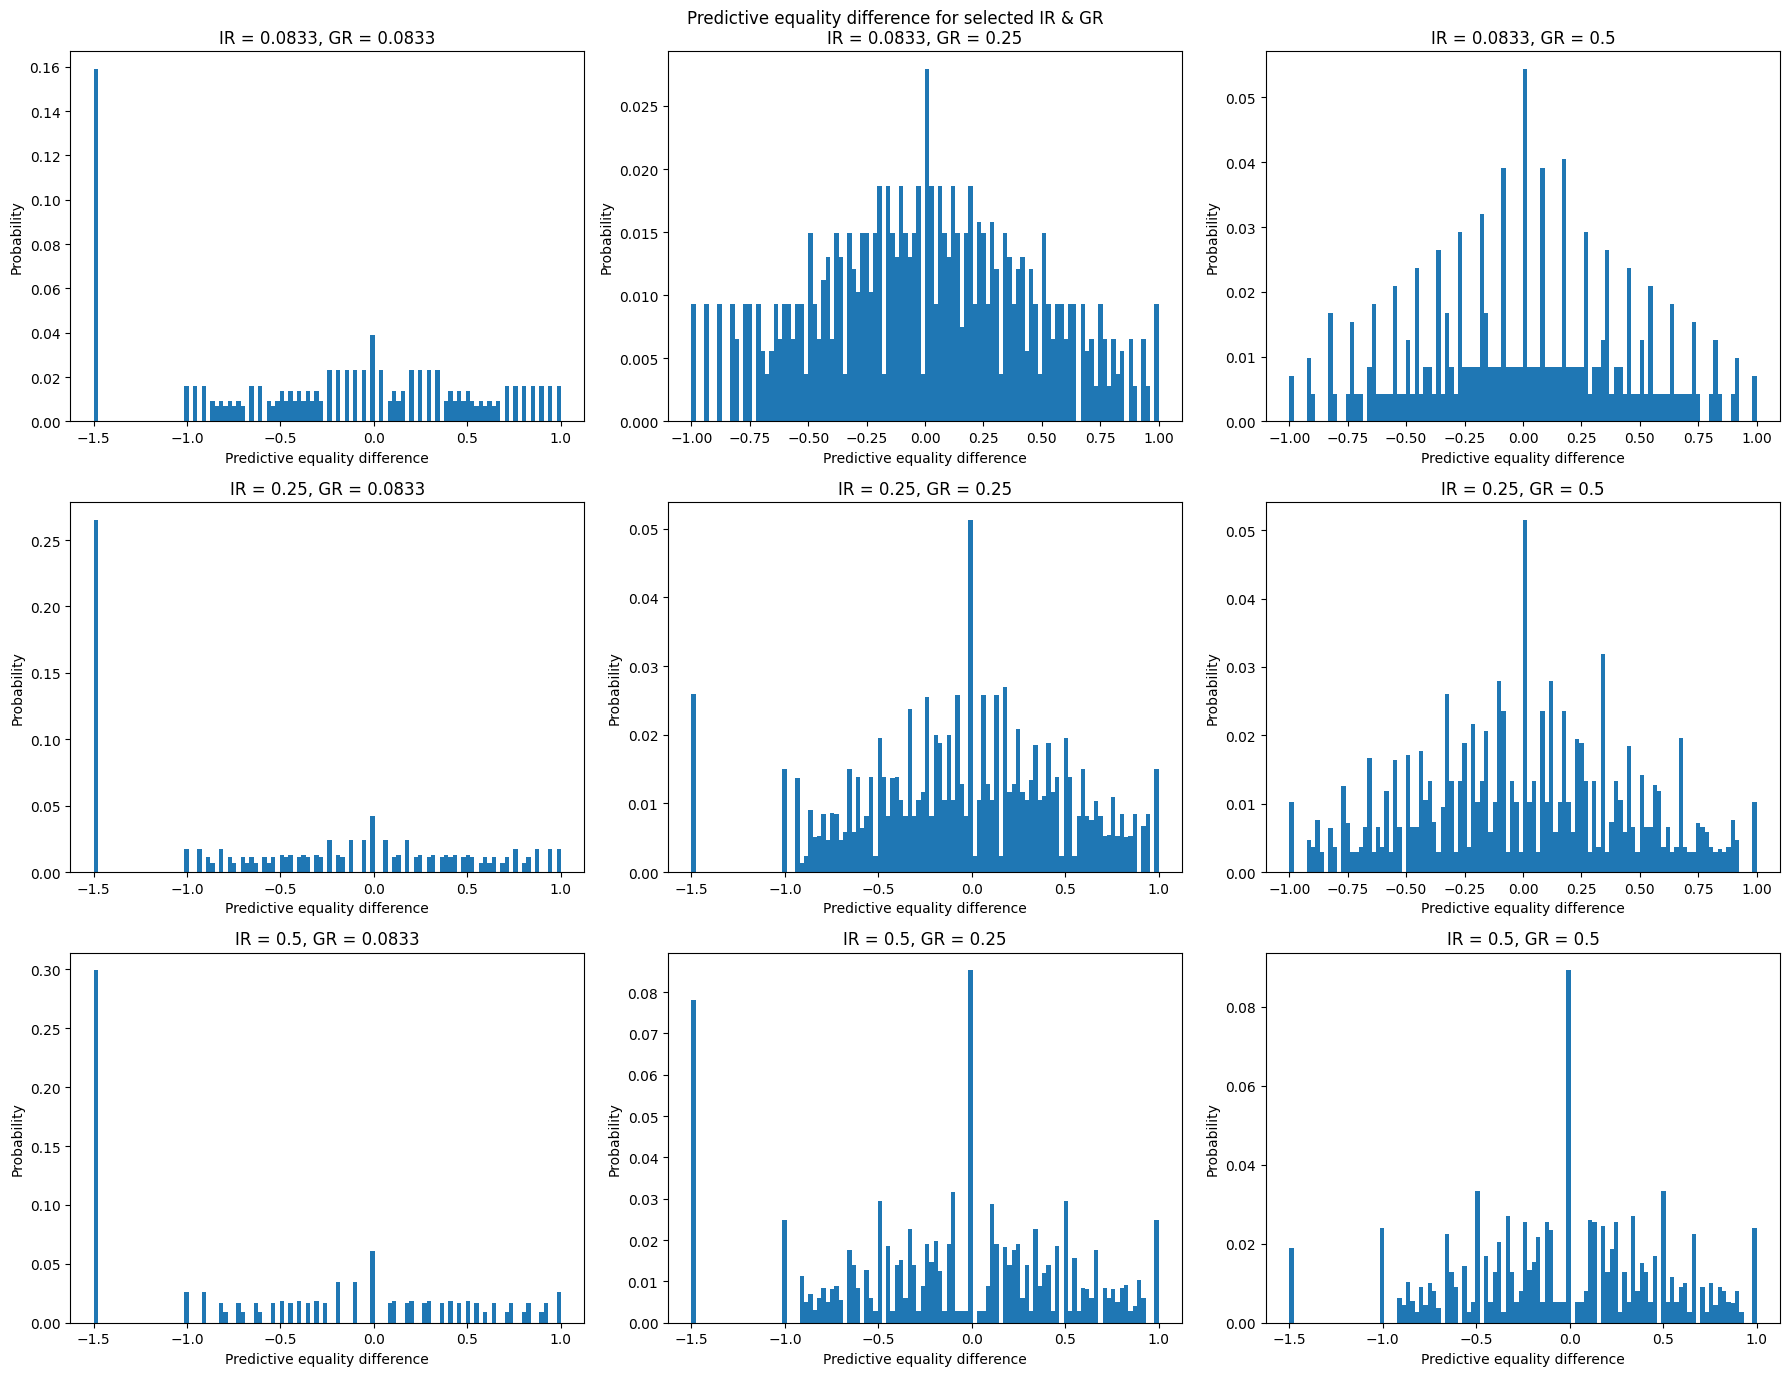

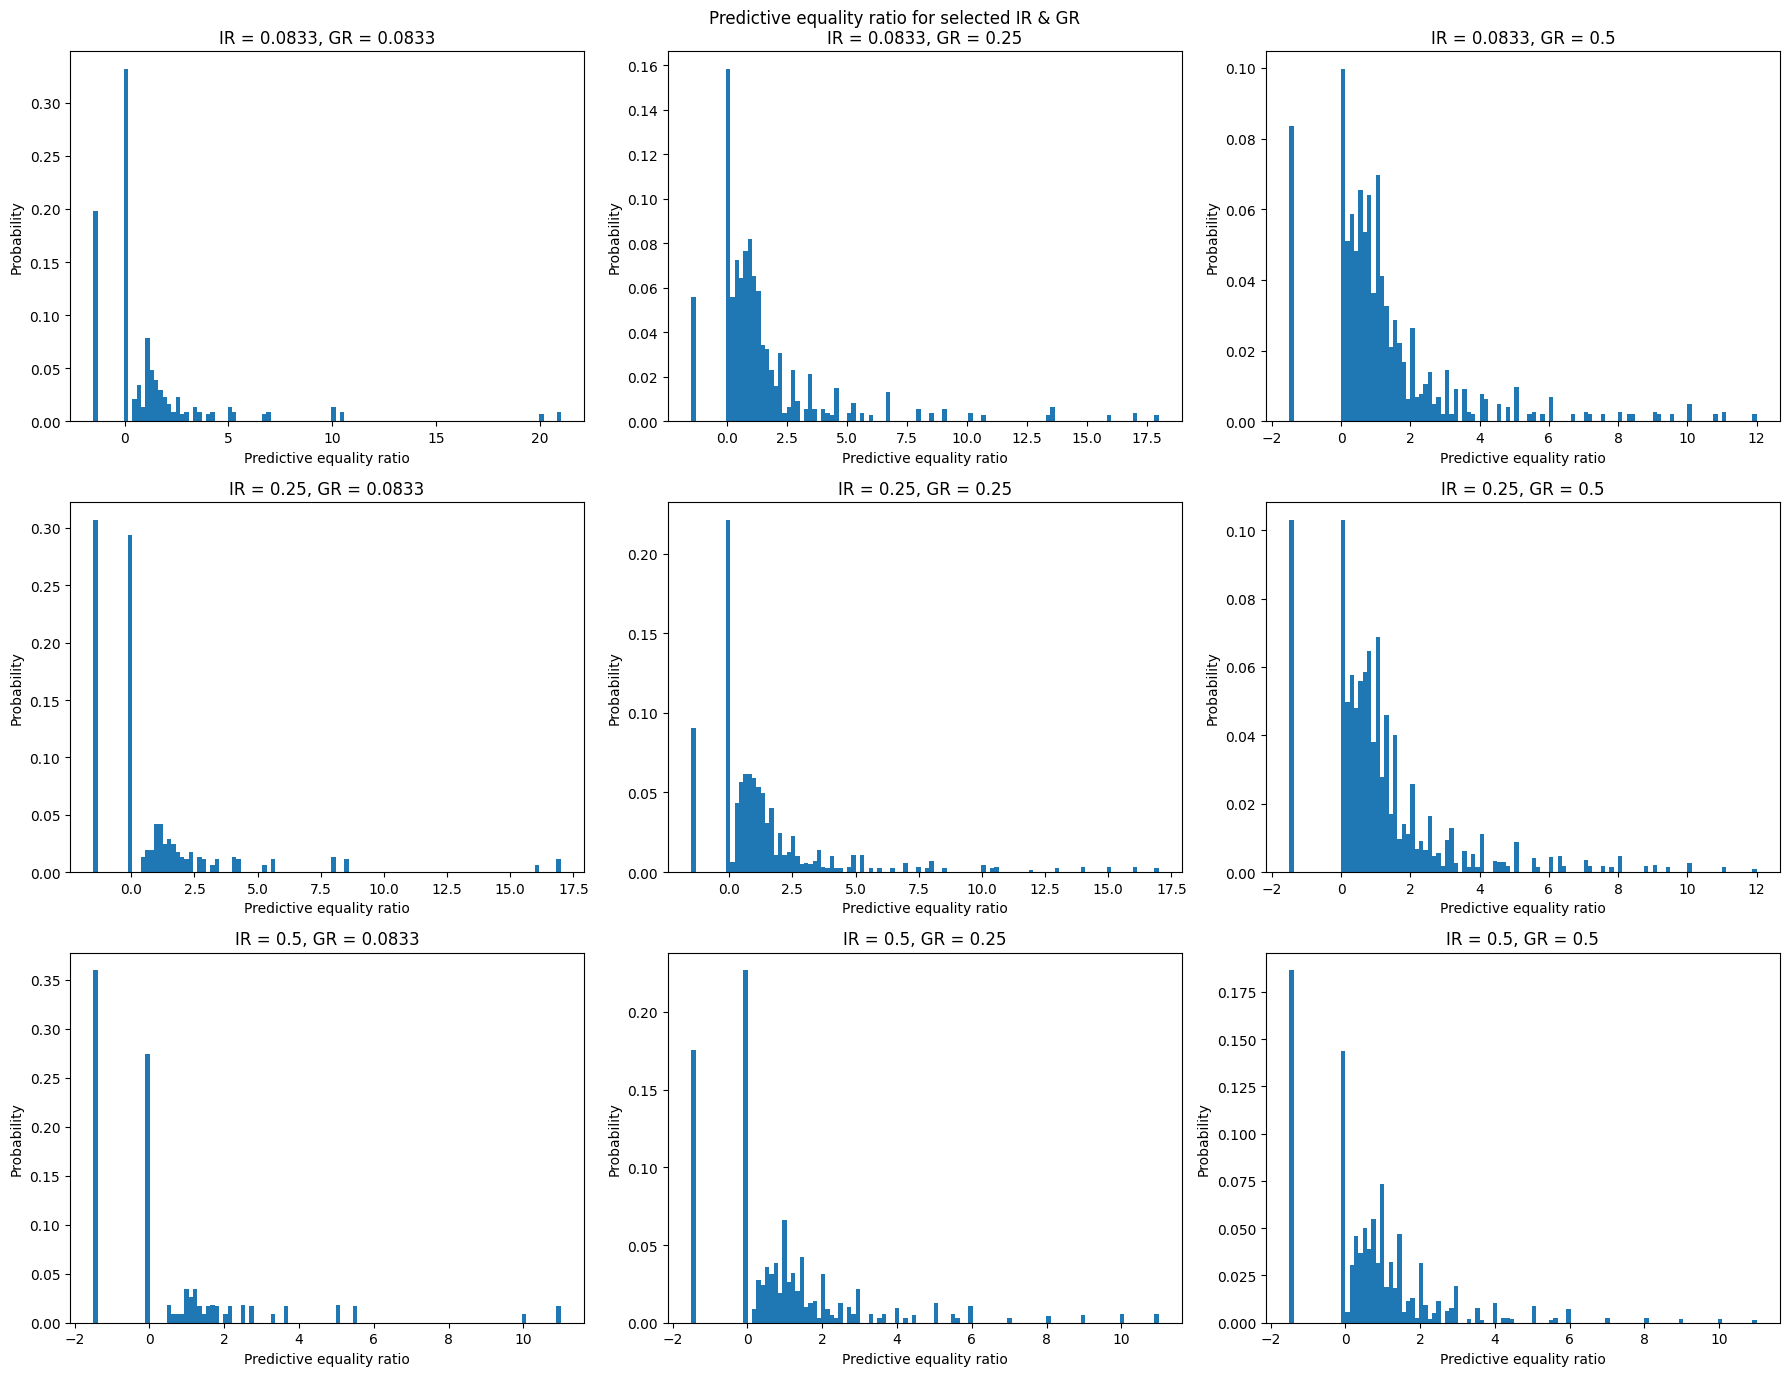

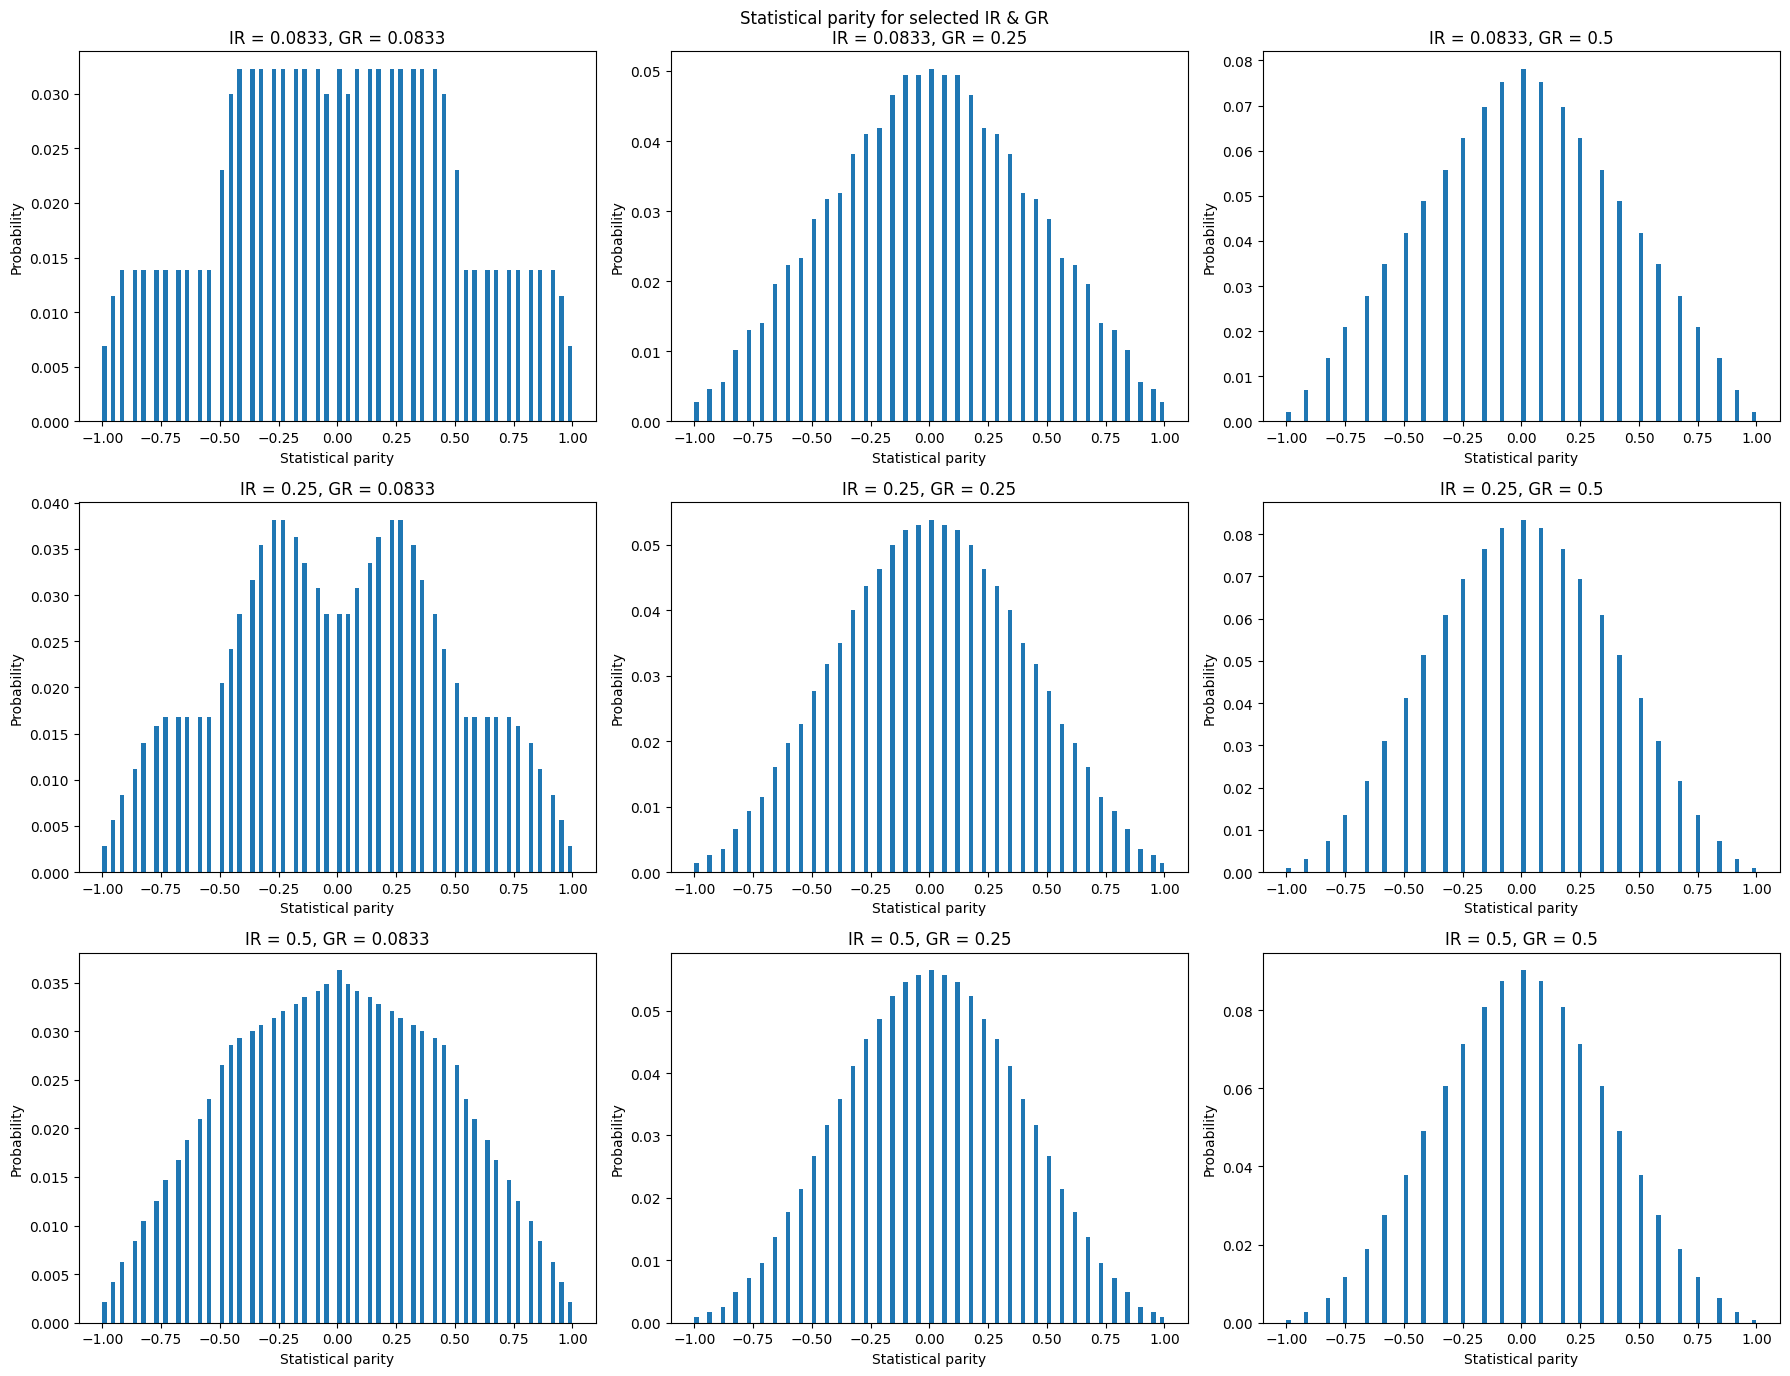

In [59]:
# don't need the symmetrical plots
gs = gr_selected[:len(gr_selected) // 2 + 1]
is_ = ir_selected[:len(ir_selected) // 2 + 1]

for metric_info in metrics.items():
    # for bins in [64, 72, 92, 108, 128]:
    bins = 108

    fig = plot_histograms_01(metric_info, gs, is_, bins)
    fig.savefig(path.join(plots_dir, f'MPL_norm_half_b{bins}_{metric_info[1]}.png'), dpi=300)
    plt.show()

## Sharing y-axis for NaNs and numbers

In [9]:
m_file, m_name= 'equal_opp_ratio.bin', 'Equal opportunity ratio'

with open(path.join(calculations_dir, m_file), 'rb') as f:
    metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[m_name])

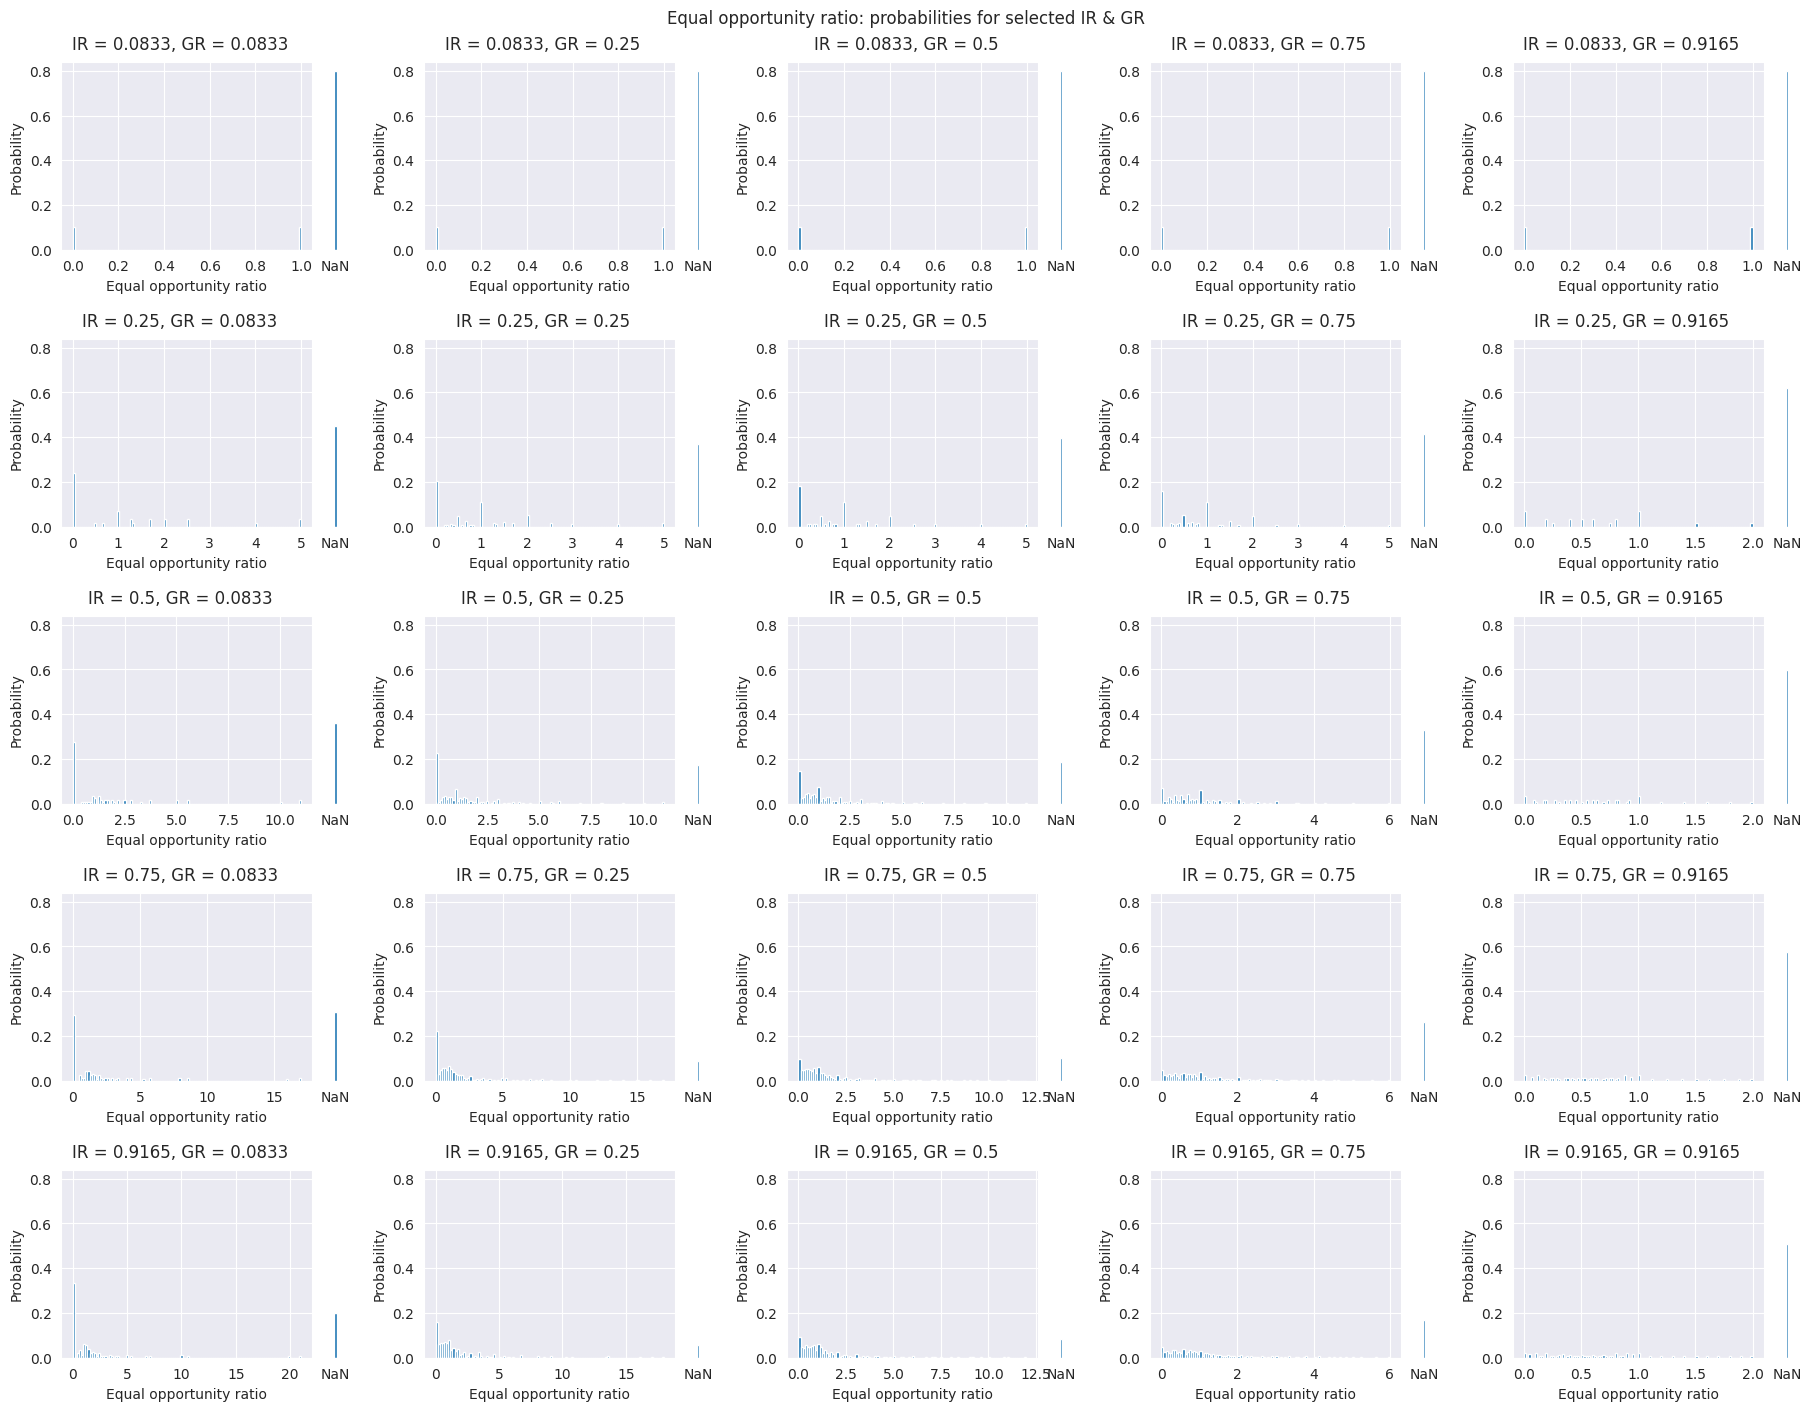

In [10]:
# Equal opportunity ratio
# with NaNs
# approach: subfigures

BINS = 108
ratios = [1./12, 1./4, 1./2, 3./4, 11./12]
grs = np.float16(ratios)
irs = np.float16(ratios)


# merge info about metric values and balance ratios
df = pd.concat([gr, ir, metric], axis=1)
# filter to get only results for selected ratios
df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]
df = df.replace(np.inf, np.nan).replace(np.nan, -2)
df['typeVal'] = np.where(df[m_name] == -2, 'NaN', 'not NaN')

# fig, ax = plt.subplots(len(irs), len(grs), figsize=(18, 14))
fig = plt.figure(figsize=(18, 14), layout='constrained')      # layout='tight'
subfigs = fig.subfigures(len(irs), len(grs), wspace=0.04, hspace=0.04)    #
y_max = 0

for i, ir_val in enumerate(irs):
    for g, gr_val in enumerate(grs):
        # set up axes
        gs = subfigs[i, g].add_gridspec(1, 2, width_ratios=[30, 1], wspace=0)
        ax = gs.subplots(sharex=False, sharey=True)        # 1, 2, sharex=False, sharey=True, width_ratios=[1, 40]
        subfigs[i, g].suptitle(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')

        # separate nans and numbers
        df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
        total = df_tmp.shape[0]
        df_not_nan = df_tmp.loc[df_tmp[m_name] != -2]
        nan_prob = 0 if total == 0 else df_tmp.loc[df_tmp[m_name] == -2].shape[0] / total

        # prepare data for plotting
        binned, edges = np.histogram(df_not_nan[m_name], bins=BINS)
        binned = 0 if total == 0 else binned / total

        # plot not nans
        ax[0].hist(edges[:-1], edges, weights=binned)
        ax[0].set_xlabel(m_name)
        ax[0].set_ylabel('Probability')

        # plot nans and label the subfigure
        ax[1].bar(0, nan_prob)
        ax[1].set_xticks([0], ['NaN'])
        ax[1].set_xlim(-1.5, 1.5)
        ax[1].set_frame_on(False)

        # y-axis limits
        y_max = max(y_max, ax[0].get_ylim()[1])

# set sharey
for i, ir_val in enumerate(irs):
    for g, gr_val in enumerate(grs):
        subfigs[i, g].subplots_adjust(top=0.9)
        subfigs[i, g].set_facecolor('white')
        subfigs[i, g].axes[0].set_ylim(0, y_max)
        # subfigs[i, g].axes[1].set_ylim(0, y_max)


fig.suptitle(f'{m_name}: probabilities for selected IR & GR')
# fig.tight_layout()
fig.savefig(path.join(plots_dir, f'MPL_withnan_constrained_{m_name}.png'), dpi=300)
plt.show()

In [25]:
def plot_histograms_02(metric_info, grs, irs, bins_n):
    m_file, m_name= metric_info

    with open(path.join(calculations_dir, m_file), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[m_name])

    df = pd.concat([gr, ir, metric], axis=1)
    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]
    df = df.replace(np.inf, np.nan).replace(np.nan, -2)
    df['typeVal'] = np.where(df[m_name] == -2, 'NaN', 'not NaN')

    fig = plt.figure(figsize=(18, 14), layout='constrained')
    subfigs = fig.subfigures(len(irs), len(grs), wspace=0.04, hspace=0.04)
    y_max = 0

    for i, ir_val in enumerate(irs):
        for g, gr_val in enumerate(grs):
            # set up axes
            gs = subfigs[i, g].add_gridspec(1, 2, width_ratios=[30, 1], wspace=0)
            ax = gs.subplots(sharex=False, sharey=True)
            subfigs[i, g].suptitle(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')

            # separate nans and numbers
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
            total = df_tmp.shape[0]
            if total != 0:
                df_not_nan = df_tmp.loc[df_tmp[m_name] != -2]
                nan_prob = df_tmp.loc[df_tmp[m_name] == -2].shape[0] / total

                # prepare data for plotting
                binned, edges = np.histogram(df_not_nan[m_name], bins=bins_n)
                binned = binned / total

                # plot not nans
                ax[0].hist(edges[:-1], edges, weights=binned, fc='black', ec='black')

                # plot nans - without drawing the axis frame
                ax[1].bar(0, nan_prob, fc='red', ec='red')

            ax[0].set_xlabel(m_name)
            ax[0].set_ylabel('Probability')
            ax[1].set_xticks([0], ['NaN'])
            ax[1].set_xlim(-1.5, 1.5)
            ax[1].tick_params(axis='x', which='both', length=0)
            ax[1].set_frame_on(False)

            # y-axis limits
            y_max = max(y_max, ax[0].get_ylim()[1])
            if i == 0 and g == 0:
                continue
            subfigs[0, 0].axes[0].sharey(ax[0])

    # set sharey
    subfigs[0, 0].axes[0].set_ylim(0, y_max)
    # for i, ir_val in enumerate(irs):
    #     for g, gr_val in enumerate(grs):
    #         # subfigs[i, g].subplots_adjust(top=0.9)
    #         # subfigs[i, g].set_facecolor('white')
    #         # subfigs[i, g].axes[0].set_ylim(0, y_max)
    #         # subfigs[i, g].axes[1].set_ylim(0, y_max)

    fig.suptitle(f'{m_name}: probabilities for selected IR & GR')

    del metric
    del df
    gc.collect()

    return fig

ValueError: y-axis is already shared

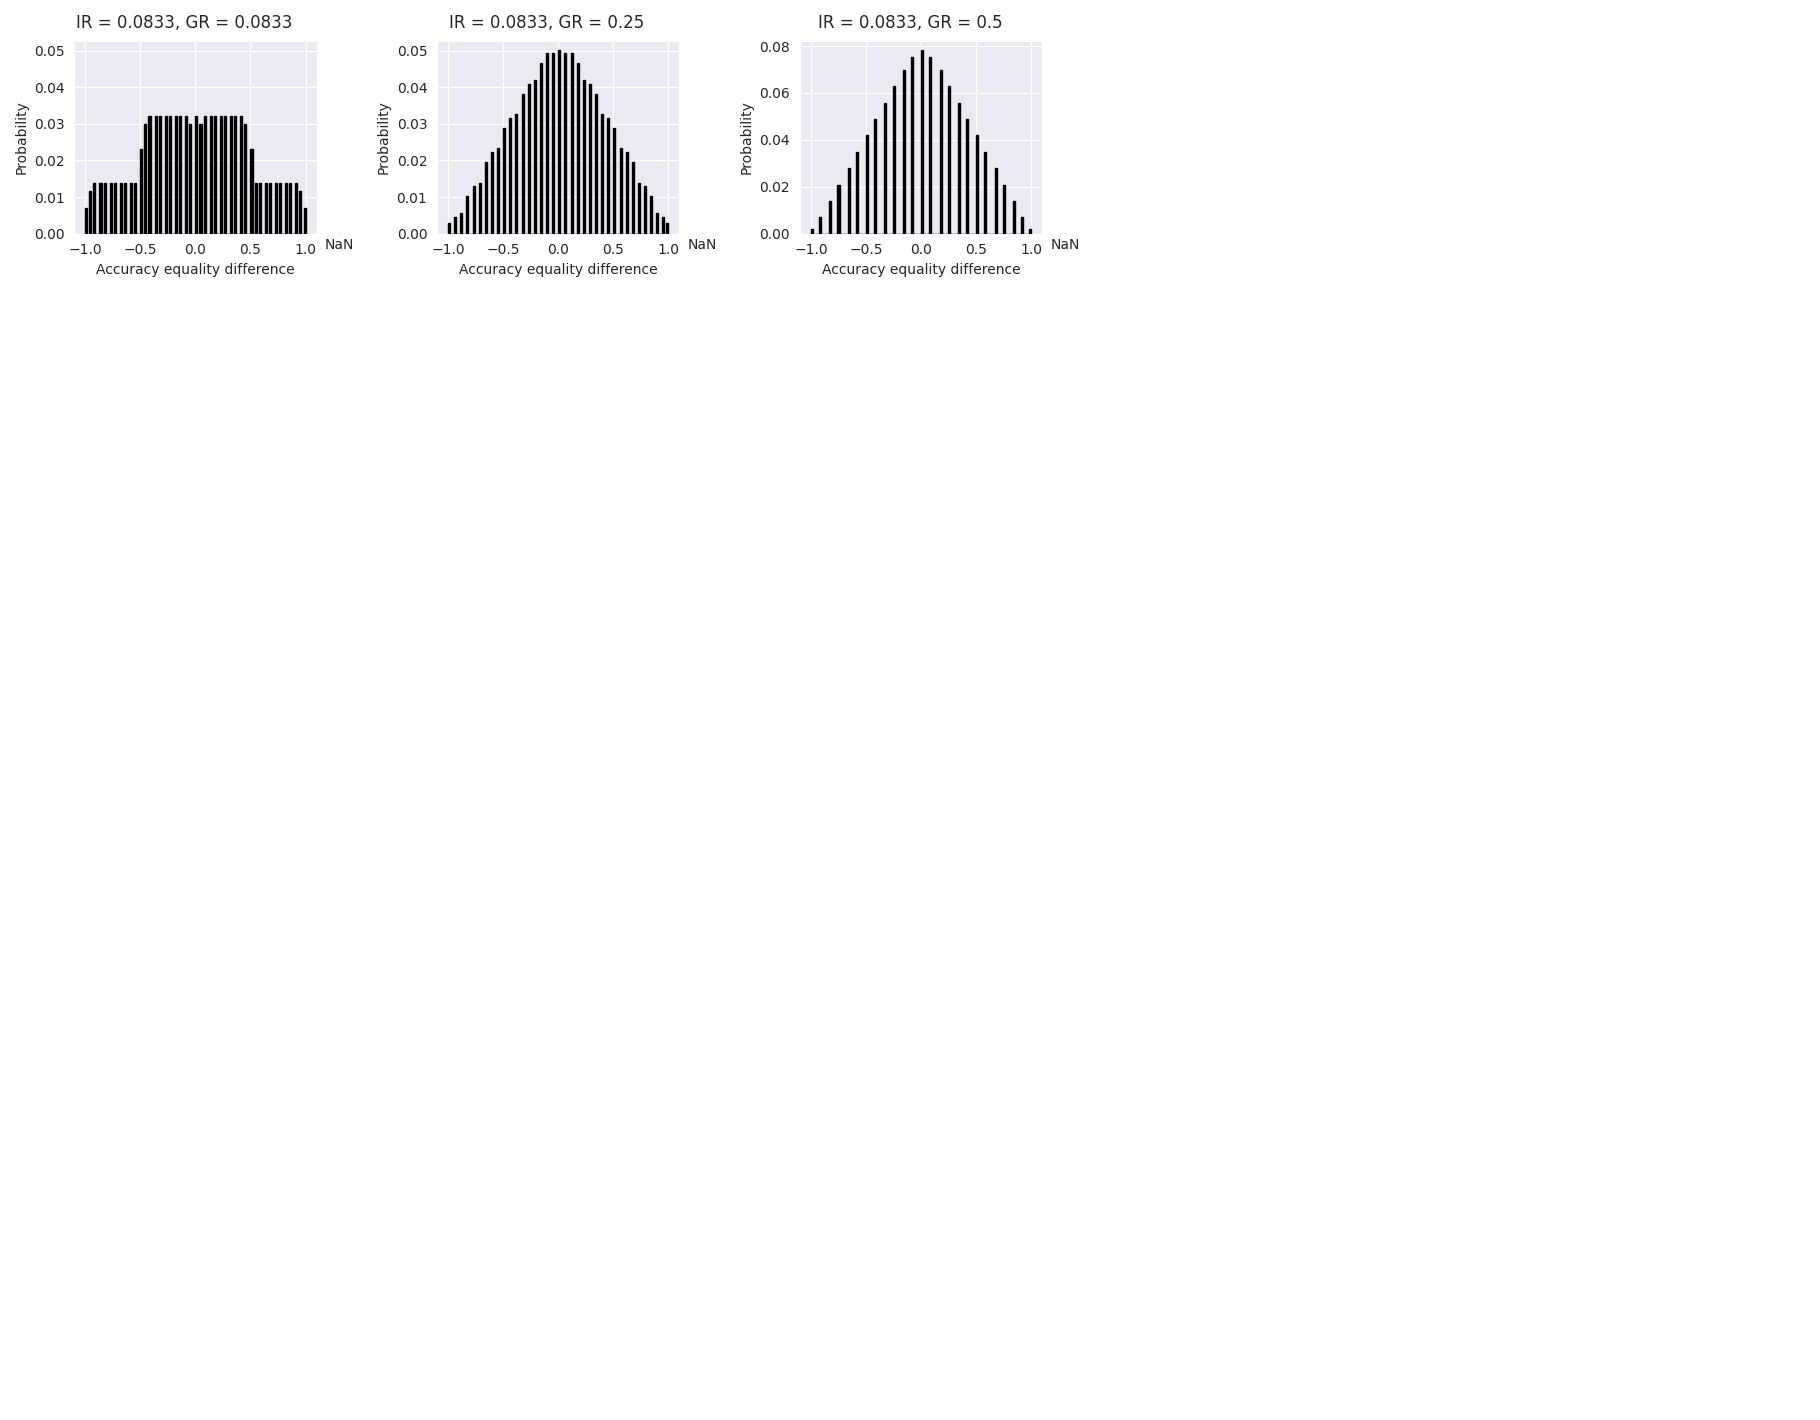

In [26]:
# ratios = [1./28, 1./4, 1./2, 3./4, 27./28]
ratios = [1./12, 1./4, 1./2, 3./4, 11./12]
grs = np.float16(ratios)
irs = np.float16(ratios)
BINS = 108

for metric_info in metrics.items():
    fig = plot_histograms_02(metric_info, grs, irs, BINS)
    fig.savefig(path.join(plots_dir, f'MPL_withnan_b{BINS}_{metric_info[1]}_sharey.png'), dpi=300)
    # plt.show()
    plt.close(fig)
    # break

### nans

Infs: 50063860
Nans: 16872171


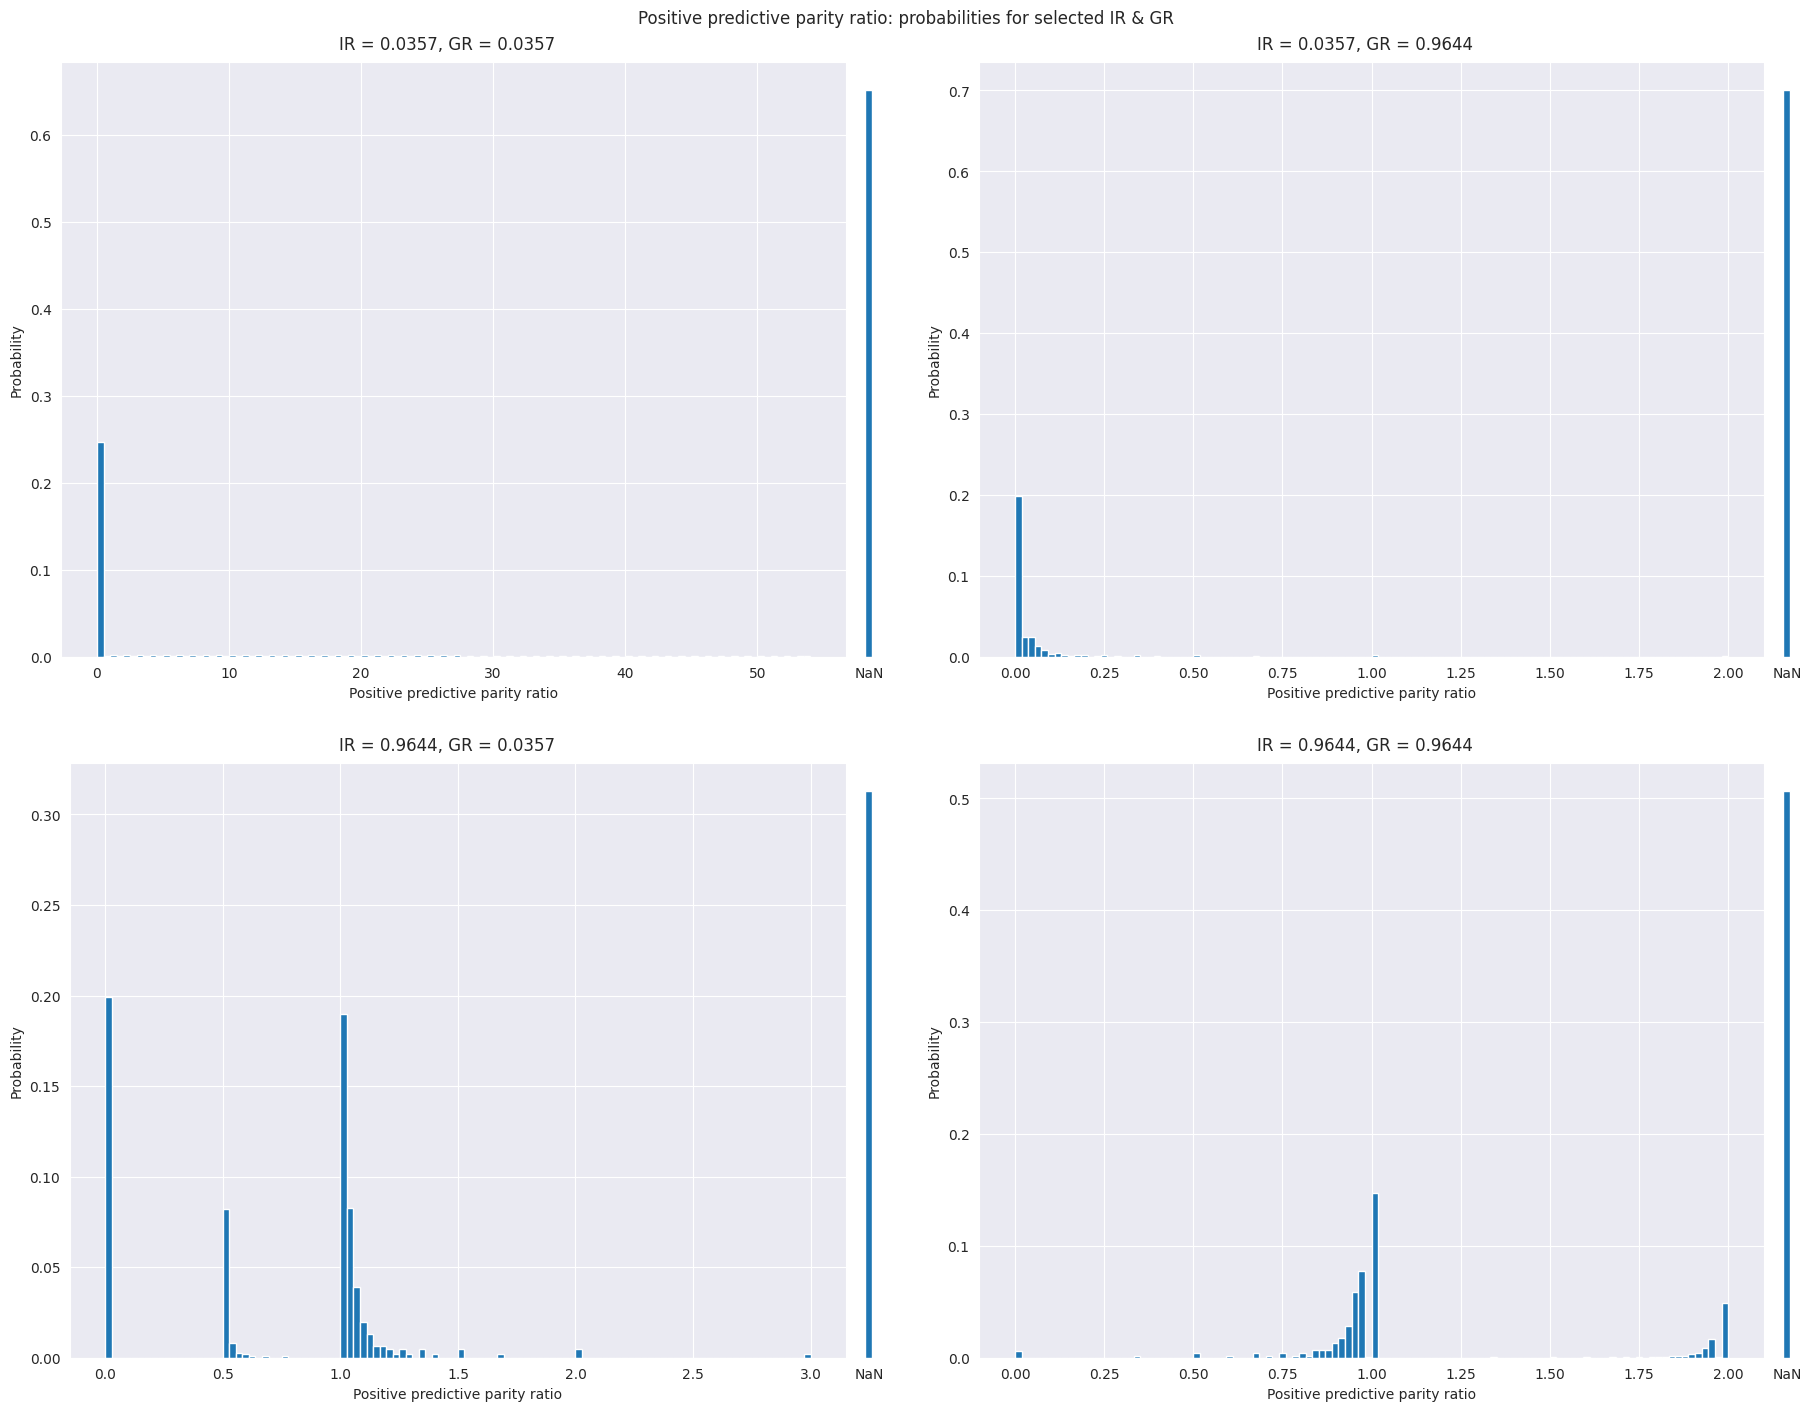

3502828

In [8]:
ratios = [1./28, 27./28]
grs = np.float16(ratios)
irs = np.float16(ratios)

# Equal opportunity ratio
# with NaNs
# approach: subfigures

BINS = 108

m_file, m_name= 'pos_pred_parity_ratio.bin', 'Positive predictive parity ratio'

with open(path.join(calculations_dir, m_file), 'rb') as f:
    metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[m_name])

# merge info about metric values and balance ratios
df = pd.concat([gr, ir, metric], axis=1)

# count infs
print(f'Infs: {df.loc[df[m_name] == np.inf].shape[0]}')
# count nans
print(f'Nans: {df.loc[df[m_name].isna()].shape[0]}')

# filter to get only results for selected ratios
df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]
df = df.replace(np.inf, np.nan).replace(np.nan, -2)
df['typeVal'] = np.where(df[m_name] == -2, 'NaN', 'not NaN')

# fig, ax = plt.subplots(len(irs), len(grs), figsize=(18, 14))
fig = plt.figure(figsize=(18, 14), layout='constrained')      # layout='tight'
subfigs = fig.subfigures(len(irs), len(grs), wspace=0.04, hspace=0.04)    #

for i, ir_val in enumerate(irs):
    for g, gr_val in enumerate(grs):
        # set up axes
        gs = subfigs[i, g].add_gridspec(1, 2, width_ratios=[30, 1], wspace=0)
        ax = gs.subplots(sharex=False, sharey=True)        # 1, 2, sharex=False, sharey=True, width_ratios=[1, 40]
        subfigs[i, g].suptitle(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')

        # separate nans and numbers
        df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
        total = df_tmp.shape[0]
        df_not_nan = df_tmp.loc[df_tmp[m_name] != -2]
        nan_prob = 0 if total == 0 else df_tmp.loc[df_tmp[m_name] == -2].shape[0] / total

        # prepare data for plotting
        binned, edges = np.histogram(df_not_nan[m_name], bins=BINS)
        binned = 0 if total == 0 else binned / total

        # plot not nans
        ax[0].hist(edges[:-1], edges, weights=binned)
        ax[0].set_xlabel(m_name)
        ax[0].set_ylabel('Probability')

        # plot nans and label the subfigure
        ax[1].bar(0, nan_prob)
        ax[1].set_xticks([0], ['NaN'])
        ax[1].set_xlim(-1.5, 1.5)
        ax[1].set_frame_on(False)

fig.suptitle(f'{m_name}: probabilities for selected IR & GR')
# fig.tight_layout()
# fig.savefig(path.join(plots_dir, f'MPL_withnan_constrained_{m_name}.png'), dpi=300)
plt.show()
del metric
del df
gc.collect()

## Share y-axis scaling with subplot mosaic

In [71]:
from matplotlib.gridspec import GridSpec
from copy import deepcopy

# mogą się przydać
# tick_params(labelleft=False, labelbottom=False)


def plot_histograms_03(metric_info, grs, irs, ratios_labels, bins_n):
    m_file, m_name= metric_info

    with open(path.join(calculations_dir, m_file), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[m_name])

    df = pd.concat([gr, ir, metric], axis=1)
    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]
    df = df.replace(np.inf, np.nan).replace(np.nan, -2)
    df['typeVal'] = np.where(df[m_name] == -2, 'NaN', 'not NaN')

    # [['a00', 'a00n', 'a01', 'a01n',...], ...]
    mosaic = [
        [f'a{i}{g}{x}' for g in range(len(grs)) for x in ['', 'n']]
        for i in range(len(irs))
    ]

    fig, axs = plt.subplot_mosaic(mosaic,
                                  width_ratios=[50, 1]*len(grs),
                                  sharex=False, sharey=True,
                                  layout='constrained', figsize=(18, 14),
                                  gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    fig.suptitle(f'{m_name}: probabilities for selected IR & GR')

    # wspace=0.04, hspace=0.04

    for i, ir_val in enumerate(irs):
        for g, gr_val in enumerate(grs):

            # separate nans and numbers
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
            total = df_tmp.shape[0]

            df_not_nan = df_tmp.loc[df_tmp[m_name] != -2]
            nan_prob = df_tmp.loc[df_tmp[m_name] == -2].shape[0] / total

            # prepare data for plotting
            binned, edges = np.histogram(df_not_nan[m_name], bins=bins_n)
            binned = binned / total

            # plot not nans
            axs[f'a{i}{g}'].hist(edges[:-1], edges, weights=binned, fc='black', ec='black')
            # axs[f'a{i}{g}'].set_title(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')
            axs[f'a{i}{g}'].spines[['top', 'right']].set_visible(False)

            # plot nans - without drawing the axis frame
            axs[f'a{i}{g}n'].bar(0, nan_prob, fc='red', ec='red', width=0.1, lw=0)
            # axs[f'a{i}{g}n'].set_xlim(-1.5, 1.5)
            # axs[f'a{i}{g}n'].set_frame_on(False)
            axs[f'a{i}{g}n'].spines[['top', 'left']].set_visible(False)

            # styling
            # # sharex
            # axs[f'a{i}{g}'].sharex(axs[f'a00'])
            # axs[f'a{i}{g}n'].sharex(axs[f'a00n'])

            # x-axis labels
            if g == 0:
                axs[f'a{i}{g}'].set_ylabel(f'IR = {ratios_labels[i]}')

            # x-axis labels
            if i == 0:
                axs[f'a{i}{g}'].set_title(f'GR = {ratios_labels[g]}')
            if i == len(irs) - 1:   # last row
                # axs[f'a{i}{g}'].set_xlabel(f'GR = {ratios_labels[g]}')
                axs[f'a{i}{g}n'].set_xticks([0], ['NaN'])
                # axs[f'a{i}{g}'].set_xticklabels([])
            else:
                axs[f'a{i}{g}'].set_xticklabels([])
                axs[f'a{i}{g}n'].set_xticks([0], [''])

    del metric
    del df
    gc.collect()

    return fig

In [75]:
ratios = [1./28, 1./4, 1./2, 3./4, 27./28]
# ratios = [1./12, 1./4, 1./2, 3./4, 11./12]
ratios_labels = ['1/28', '1/4', '1/2', '3/4', '27/28']
# ratios_labels = ['1/12', '1/4', '1/2', '3/4', '11/12']
grs = np.float16(ratios)
irs = np.float16(ratios)
BINS = 108

for metric_info in metrics.items():
    fig = plot_histograms_03(metric_info, grs, irs, ratios_labels, BINS)
    fig.savefig(path.join(plots_dir, f'hist_b{BINS}_{metric_info[1]}_sharey.png'), dpi=300)
    # plt.show()
    plt.close(fig)
    # break